### Importing and cleaning Attendance (excel) data

In [1]:
pip install xlrd==1.2.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import glob as glob_lib
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
import matplotlib.pyplot as plt    
from scipy import stats 
import statsmodels.formula.api as sm

In [3]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 50)

In [5]:
all_data = pd.DataFrame()
for file_path in glob_lib.glob('C:/Users/bonne/Downloads/Data/*.xls*'):
    print(file_path)
    sheets = pd.ExcelFile(file_path, engine="xlrd").book.sheets()
    visible_sheets = [sheet for sheet in sheets if (sheet.visibility == 0)]
    sheets_to_keep = [sheet.name for sheet in visible_sheets if (sheet.cell_value(0,1) == 'Day')]
    workbook = pd.read_excel(file_path, sheet_name = sheets_to_keep, header = [0,1], nrows = 33)
    for k,v in workbook.items(): 
        for col in v.columns:
            if col[0] in ['PrePay', 'Pre-Pay'] or col[1] in ['PrePay', 'Pre-Pay']:
                v.drop(col, axis = 1, inplace = True)
        v.columns = range(len(v.columns))
    current_workbook = pd.concat(workbook)
    all_data = pd.concat([all_data, current_workbook])
df_with_workbook_cols = pd.read_excel('C:/Users/bonne/Downloads/Data/FY 2018 _ 2019.xlsx', sheet_name=10, header=[0,1], nrows=1)
flat_column_names = [col[0].replace("\n", "") if col[1].startswith('Unnamed:') else col[0] + " " + col[1] for col in df_with_workbook_cols.columns][:-1]
all_data = all_data.iloc[:,:16]
all_data.columns = flat_column_names
attendance = all_data.copy()
attendance = attendance[pd.notnull(attendance.Day)]
print(attendance)

C:/Users/bonne/Downloads/Data\FY 2014 _ 2015.xls
C:/Users/bonne/Downloads/Data\FY 2015 _ 2016.xls
C:/Users/bonne/Downloads/Data\FY 2016 _ 2017.xlsx


<ipython-input-5-c03a823c65a7>:4: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  sheets = pd.ExcelFile(file_path, engine="xlrd").book.sheets()


C:/Users/bonne/Downloads/Data\FY 2017 _ 2018.xlsx
C:/Users/bonne/Downloads/Data\FY 2018 _ 2019.xlsx
                          Date   Day  Full Paid  Discount Paid  Comp. Visitors  Member  Guest Passes Member Guest  Guest Passes Pre-Paid  GroupSales College Education Ed Groups  Education Public Act.  Special Events Member Events  Special Events Paid Sp Events  Total On-Site Visitors       Happenings
JUL 14 0   2014-07-01 00:00:00  Tues      430.0          340.0            61.0    87.0                       21.0                  273.0         0.0     0.0                72.0                    NaN                           NaN                            NaN                  1284.0              NaN
       1   2014-07-02 00:00:00   Wed      516.0          351.0            85.0    82.0                       18.0                   43.0       500.0     6.0                57.0                    NaN                           NaN                            NaN                  1658.0            

In [16]:
attendance.dtypes
attendance.Date = attendance.Date.astype(str)
print(attendance.Date.sort_values(ascending=True).head(20))
attendance.loc[attendance.Date=='2012-11-13 00:00:00','Date'] = '2014-11-13 00:00:00'
print(attendance.Date.sort_values(ascending=False).head(20))
attendance.loc[attendance.Date=='9/16/204','Date'] = '2014-09-16 00:00:00'


Nov 14  12    2012-11-13 00:00:00
JUL 14  0     2014-07-01 00:00:00
        1     2014-07-02 00:00:00
        2     2014-07-03 00:00:00
        3     2014-07-04 00:00:00
        4     2014-07-05 00:00:00
        5     2014-07-06 00:00:00
        6     2014-07-07 00:00:00
        7     2014-07-08 00:00:00
        8     2014-07-09 00:00:00
        9     2014-07-10 00:00:00
        10    2014-07-11 00:00:00
        11    2014-07-12 00:00:00
        12    2014-07-13 00:00:00
        13    2014-07-14 00:00:00
        14    2014-07-15 00:00:00
        15    2014-07-16 00:00:00
        16    2014-07-17 00:00:00
        17    2014-07-18 00:00:00
        18    2014-07-19 00:00:00
Name: Date, dtype: object
June  29    2019-06-30 00:00:00
      28    2019-06-29 00:00:00
      27    2019-06-28 00:00:00
      26    2019-06-27 00:00:00
      25    2019-06-26 00:00:00
      24    2019-06-25 00:00:00
      23    2019-06-24 00:00:00
      22    2019-06-23 00:00:00
      21    2019-06-22 00:00:00
      

In [17]:
attendance
attendance['Date'] = pd.to_datetime(attendance['Date'])
attendance = attendance.set_index('Date')
#all_data = all_data.dropna(subset=['Date'])

In [18]:
attendance = attendance[:'2019-01-01'].copy()

In [19]:
attendance.dtypes
attendance.College = attendance.College.astype(float)
attendance['Education Ed Groups'] = attendance['Education Ed Groups'].astype(float)

In [20]:
attendance[attendance['Full Paid'].isnull()]
attendance = attendance[attendance['Full Paid'].notnull()].copy()

In [21]:
attendance.fillna(0, inplace=True)

In [22]:
attendance[attendance['Total On-Site Visitors'] != attendance.iloc[:,1:13].sum(axis=1)]
attendance['Total On-Site Visitors'] = attendance.iloc[:,1:13].sum(axis=1)

In [23]:
#Calculate the DV and two IVs and only keep these three columns plus Happenings.
attendance['Attendance'] = attendance['Total On-Site Visitors'] -  attendance['Education Ed Groups'] - attendance['Education Public Act.'] - attendance['Special Events Member Events'] - attendance['Special Events Paid Sp Events']

attendance['Education_Attendance'] = attendance['Education Ed Groups'] + attendance['Education Public Act.']

attendance['Special_Event_Attendance'] = attendance['Special Events Member Events'] + attendance['Special Events Paid Sp Events']

attendance = attendance[['Attendance', 'Education_Attendance', 'Special_Event_Attendance', 'Happenings']].copy()

In [13]:
#Examine the data to confirm that everything looks OK
attendance.describe()

,Attendance,Education_Attendance,Special_Event_Attendance
count,1630.000000,1630.000000,1630.000000
mean,1093.585276,122.860123,56.709202
std,571.555413,131.446297,140.125928
min,202.000000,0.000000,0.000000
25%,612.000000,25.000000,0.000000
50%,997.000000,88.000000,0.000000
75%,1454.250000,178.750000,74.000000
max,3566.000000,1329.000000,1284.000000


In [25]:
attendance.to_csv('C:/Users/shani/Downloads/Data (1).csv')

In [26]:
attendance

,Attendance,Education_Attendance,Special_Event_Attendance,Happenings
Date,,,,
2014-07-01,1212.0,72.0,0.0,0
2014-07-02,1601.0,57.0,0.0,0
2014-07-03,1183.0,8.0,0.0,0
2014-07-04,968.0,0.0,425.0,0
2014-07-05,2499.0,25.0,16.0,BofA in prepaid
...,...,...,...,...
2018-12-27,2388.0,62.0,0.0,0
2018-12-28,2566.0,26.0,0.0,0
2018-12-29,2392.0,57.0,0.0,0


### Importing and cleaning Weather data

In [47]:
weather = pd.concat((pd.read_csv(file) for file in glob_lib.glob('C:/Users/shani/Downloads/Data (1)/*.csv*')), sort= False)

In [48]:
weather_copy = weather.copy()

In [49]:
weather_copy['ObservationTimeUtc'] = pd.to_datetime(weather_copy['ObservationTimeUtc'], utc=True)
weather_copy = weather_copy.set_index(['ObservationTimeUtc']).sort_index()

In [50]:
weather_copy.index = weather_copy.index.tz_convert('US/Pacific')

In [51]:
weather_copy.index = weather_copy.index.tz_localize(None)

In [53]:
weather_copy = weather_copy['2014-07-01':]

In [52]:
weather_copy = weather_copy[['Humidity', 'TemperatureC', 'RainMillimetersRatePerHour', 'WindSpeedKph', 'Humidity-QcDataDescriptor']]

In [54]:
def create_box_and_dist_plots(col):
    plt.figure()
    sns.boxplot(x=col[pd.notnull(col)]) #only plot not null values (error if NaN values are plotted)
    plt.figure()    
    sns.distplot(col[pd.notnull(col)], kde=False, fit=stats.norm) 

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


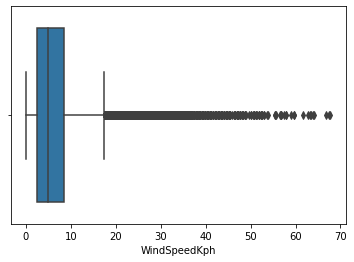

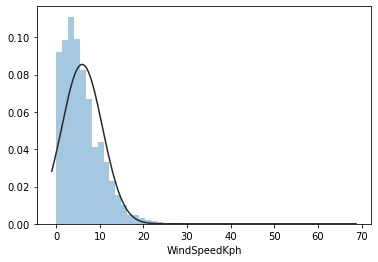

In [55]:
#### Wind ####
create_box_and_dist_plots(weather_copy.WindSpeedKph)

In [56]:
print(weather_copy.WindSpeedKph[weather_copy.WindSpeedKph>55].sort_index)

<bound method Series.sort_index of ObservationTimeUtc
2016-01-06 14:55:01    55.739878
2016-01-07 02:25:00    59.620502
2016-01-31 18:05:01    55.387094
2016-01-31 19:04:59    63.501126
2016-01-31 19:29:59    64.206695
2016-01-31 19:40:00    67.734535
2016-01-31 20:30:00    62.795558
2016-01-31 21:05:00    57.503798
2016-01-31 21:35:00    63.853911
2016-01-31 22:05:00    66.676183
2016-01-31 23:19:59    56.445446
2016-02-01 00:10:00    58.914934
2016-02-01 00:50:00    55.387094
2016-02-01 01:30:00    57.856582
2016-02-01 01:35:01    63.148342
2016-02-01 02:10:02    56.798230
2016-02-01 02:24:59    61.737206
2016-02-01 02:40:01    59.620502
2016-03-07 15:10:00    67.381751
2017-02-17 12:20:00    57.856582
2017-02-17 14:20:00    56.798230
2017-02-17 16:15:00    56.798230
Name: WindSpeedKph, dtype: float64>


C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


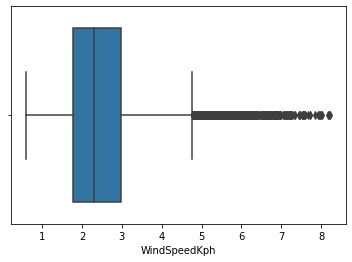

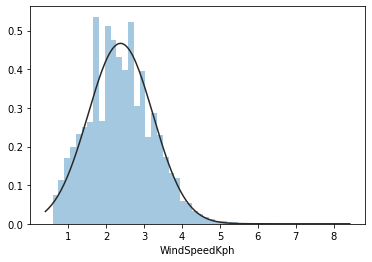

In [57]:
create_box_and_dist_plots(np.sqrt(weather_copy.WindSpeedKph[weather_copy.WindSpeedKph>0]))

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


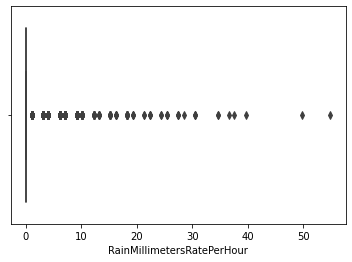

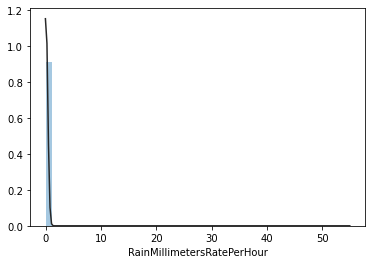

In [58]:
#### Rain ####
create_box_and_dist_plots(weather_copy.RainMillimetersRatePerHour)

In [59]:
print(weather_copy.RainMillimetersRatePerHour[weather_copy.RainMillimetersRatePerHour>20].sort_index())

ObservationTimeUtc
2015-07-18 13:55:00    34.544
2015-07-18 14:00:00    36.576
2015-07-19 15:05:02    22.352
2015-11-03 19:40:00    22.352
2016-01-06 15:05:01    27.432
2016-01-06 15:09:59    28.448
2016-01-06 15:30:00    22.352
2016-01-06 15:35:00    21.336
2016-01-06 15:39:58    49.784
2016-01-06 15:45:00    54.864
2016-01-06 15:50:01    24.384
2016-01-06 16:00:00    34.544
2016-01-06 16:04:59    25.400
2017-01-20 14:35:00    21.336
2017-02-17 18:45:00    25.400
2017-02-17 18:50:01    24.384
2017-02-17 18:54:59    27.432
2017-02-17 18:59:59    30.480
2017-02-17 19:05:00    30.480
2017-02-17 19:09:59    30.480
2017-05-01 14:09:59    27.432
2017-05-01 14:15:00    25.400
2017-05-01 14:35:02    37.592
2017-05-01 14:40:01    39.624
Name: RainMillimetersRatePerHour, dtype: float64


C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<bound method Series.sort_index of ObservationTimeUtc
2017-03-15 12:19:59   -73.345534
2017-03-15 12:25:00   -73.345534
2017-03-15 12:25:05   -73.345534
2017-03-15 12:30:01   -73.345534
2017-03-15 12:35:00   -73.345534
2017-03-15 12:40:01   -73.345534
2017-03-15 12:45:00   -73.345534
2017-03-15 12:50:00   -73.345534
2017-03-15 12:54:59   -73.345534
2017-03-15 12:59:59   -73.345534
2017-03-15 13:04:59   -73.345534
2017-03-17 07:15:00   -73.345534
2017-03-17 07:20:00   -73.345534
2017-03-17 07:24:59   -73.345534
2017-03-17 07:25:01   -73.345534
2017-03-17 07:29:58   -73.345534
2017-03-17 07:35:01   -73.345534
2017-03-17 07:40:01   -73.345534
2017-03-17 07:44:04   -73.345534
2017-03-17 07:44:05   -73.345534
2017-05-01 11:24:59   -73.345534
2017-05-01 11:30:02   -73.345534
2017-05-01 11:35:00   -73.345534
2017-05-01 11:40:00   -73.345534
2017-05-01 11:45:00   -73.345534
2017-05-01 11:48:45   -73.345534
Name: TemperatureC, dtype: float64>


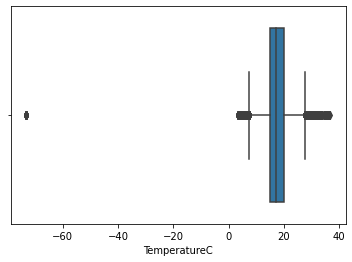

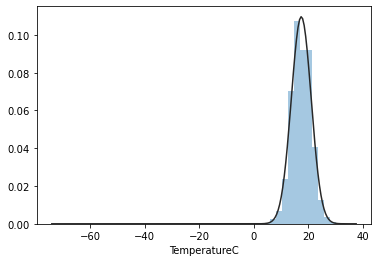

In [60]:
#### Temperature ####
create_box_and_dist_plots(weather_copy.TemperatureC)
#Temps below 0 look odd
print(weather_copy.TemperatureC[weather_copy.TemperatureC<-70].sort_index)

In [61]:
weather_copy.TemperatureC['2017-03-15 12:00':'2017-03-15 19:20']
weather_copy['2017-03-15 19:09':'2017-03-16 02:09:59']

<ipython-input-61-a8f5fea03da7>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  weather_copy.TemperatureC['2017-03-15 12:00':'2017-03-15 19:20']
<ipython-input-61-a8f5fea03da7>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  weather_copy['2017-03-15 19:09':'2017-03-16 02:09:59']


,Humidity,TemperatureC,RainMillimetersRatePerHour,WindSpeedKph,Humidity-QcDataDescriptor
ObservationTimeUtc,,,,,
2017-03-15 19:09:59,72.462425,16.561002,0.0,1.763920,Q
2017-03-15 19:15:01,72.984838,16.406427,0.0,0.000000,Q
2017-03-15 19:20:00,72.212102,16.219063,0.0,4.233408,Q
2017-03-15 19:25:01,67.379779,15.844336,0.0,3.175056,Q
2017-03-15 19:30:01,67.292710,15.998911,0.0,0.000000,Q
...,...,...,...,...,...
2017-03-16 01:50:00,77.458002,15.216667,0.0,1.763920,Q
2017-03-16 01:56:09,77.588606,15.249455,0.0,1.763920,Q
2017-03-16 02:00:00,74.051432,15.183878,0.0,0.000000,Q


In [62]:
#Similar thing happened two days later: 2017-03-17
weather_copy.TemperatureC['2017-03-17 07':'2017-03-17 16']

#Similar thing happened on may 1st 2017
weather_copy.TemperatureC['2017-05-01 11:19':'2017-05-01 13:26']

<ipython-input-62-56467aa41e19>:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  weather_copy.TemperatureC['2017-05-01 11:19':'2017-05-01 13:26']


ObservationTimeUtc
2017-05-01 11:19:59    32.529085
2017-05-01 11:24:59   -73.345534
2017-05-01 11:30:02   -73.345534
2017-05-01 11:35:00   -73.345534
2017-05-01 11:40:00   -73.345534
2017-05-01 11:45:00   -73.345534
2017-05-01 11:48:45   -73.345534
2017-05-01 13:25:16    26.374183
Name: TemperatureC, dtype: float64

In [63]:
#Setting all temparature errors to NaN:
weather_copy.TemperatureC[weather_copy.TemperatureC<-10] = np.NaN

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


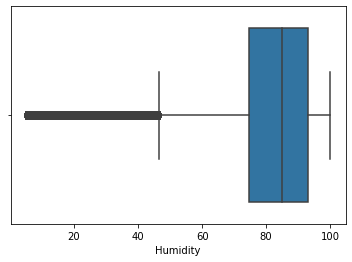

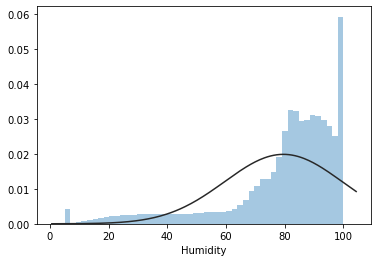

In [64]:
#### Humidity ####
create_box_and_dist_plots(weather_copy.Humidity)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


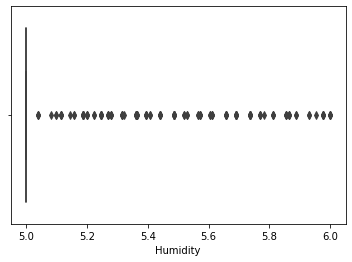

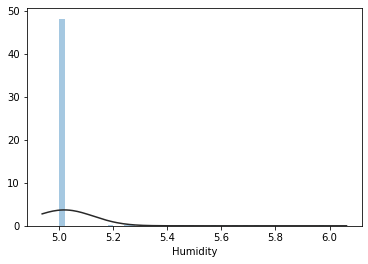

In [65]:
create_box_and_dist_plots(weather_copy.Humidity[weather_copy.Humidity<6])

In [66]:
weather_copy.TemperatureC[weather_copy.Humidity<6].iloc[200:220]

ObservationTimeUtc
2016-11-07 10:45:01    16.809259
2016-11-07 10:50:00    17.123094
2016-11-07 10:55:00    17.123094
2016-11-07 10:59:58    17.188671
2016-11-07 11:05:00    17.310458
2016-11-07 11:10:00    17.155882
2016-11-07 11:14:59    16.809259
2016-11-07 11:20:01    17.029412
2016-11-07 11:24:59    17.090305
2016-11-07 11:30:00    17.249564
2016-11-07 11:35:00    17.404139
2016-11-07 11:39:59    17.591503
2016-11-07 11:44:59    17.530610
2016-11-07 11:50:00    17.469717
2016-11-07 11:55:02    17.563399
2016-11-07 11:59:59    17.591503
2016-11-07 12:02:58    17.685185
2016-11-07 12:10:00    17.999020
2016-11-07 12:15:00    17.778867
2016-11-07 12:19:59    17.685185
Name: TemperatureC, dtype: float64

In [67]:
weather_copy.Humidity[(weather_copy['Humidity-QcDataDescriptor']=='Q')&((weather_copy.Humidity<10)|(weather_copy.Humidity==100))] = np.NaN
weather_copy.drop('Humidity-QcDataDescriptor', inplace=True, axis=1)

In [68]:
hourly_humidity = weather_copy.Humidity.resample('H').mean()
hourly_humidity = pd.DataFrame(hourly_humidity)
hourly_humidity['month'] = hourly_humidity.index.month
hourly_humidity['hour'] = hourly_humidity.index.hour

<AxesSubplot:xlabel='hour', ylabel='Humidity'>

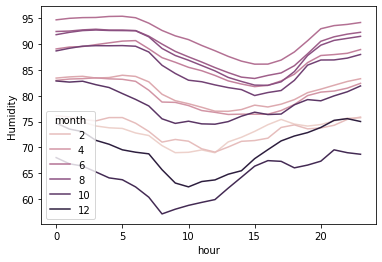

In [69]:
sns.lineplot(x="hour", y="Humidity", hue="month", data=hourly_humidity, ci=None)


<AxesSubplot:xlabel='hour', ylabel='Humidity'>

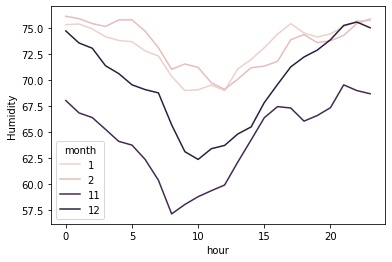

In [70]:
sns.lineplot(x="hour", y="Humidity", hue="month", data=hourly_humidity[hourly_humidity.month.isin([11,12,1,2])], ci=None)


In [71]:
weather_copy["TimeDiff"]=weather_copy.index.to_series()-weather_copy.index.to_series().shift(1)
weather_copy.TimeDiff[weather_copy.TimeDiff.dt.seconds>60*6]

ObservationTimeUtc
2014-07-02 08:40:00   0 days 00:06:02
2014-07-02 12:21:04   0 days 00:06:03
2014-07-04 02:45:01   0 days 00:06:45
2014-07-04 08:00:00   0 days 00:07:01
2014-07-06 02:46:12   0 days 00:06:14
                            ...      
2018-12-29 19:19:59   0 days 00:07:04
2018-12-30 01:40:01   0 days 00:07:12
2018-12-30 12:25:01   0 days 00:06:13
2018-12-31 08:40:01   0 days 00:07:21
2018-12-31 10:35:00   0 days 00:07:02
Name: TimeDiff, Length: 3165, dtype: timedelta64[ns]

In [72]:
dayss = weather_copy.resample('D').Humidity.count()
dayss[dayss<100]

ObservationTimeUtc
2014-07-16    24
2014-07-17    24
2014-07-18    24
2014-07-19    24
2014-07-20    24
2014-07-21    24
2015-10-21     0
2015-10-22     0
2015-10-23     0
2015-10-24     0
2015-10-25     0
2015-10-26     0
2015-10-27     0
2016-11-15    86
2016-12-05    53
2016-12-06     0
2016-12-07    52
2016-12-09    88
2016-12-10     0
2016-12-11     0
2016-12-12     0
2016-12-13     0
2016-12-14     0
2019-01-01     1
Name: Humidity, dtype: int64

In [73]:
weather_copy_subset = weather_copy['2015-10-10 15:20:00':'2015-10-18 13:20:00'].reset_index()
weather_copy_subset.ObservationTimeUtc = weather_copy_subset.ObservationTimeUtc + pd.DateOffset(days=10)
weather_copy_subset.set_index('ObservationTimeUtc', inplace=True)
weather_copy = pd.concat([weather_copy, weather_copy_subset], join='inner')

<ipython-input-73-ecb1a58bee6b>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  weather_copy_subset = weather_copy['2015-10-10 15:20:00':'2015-10-18 13:20:00'].reset_index()


In [75]:
weather_copy.to_csv('C:/Users/shani/Downloads/Data (1)/Birch_weather_cleaned.csv')

In [76]:
#### Morning Weather ####
morning_averages = weather_copy.between_time('8:00', '11:00')[['Humidity', 'TemperatureC', 'RainMillimetersRatePerHour', 'WindSpeedKph']].resample('D').mean()
morning_averages.columns = morning_averages.columns + "_morning_means"

In [77]:
#### Open Hours Weather ####
open_averages = weather_copy.between_time('9:00', '17:00')[['Humidity', 'TemperatureC', 'RainMillimetersRatePerHour', 'WindSpeedKph']].resample('D').agg(['mean', 'max'])


In [78]:
#Add open to all columns headers and also combine level 0 and level 1 of multi index values
open_averages.columns = open_averages.columns.get_level_values(0) + "_open_" + open_averages.columns.get_level_values(1)


In [79]:
#### Prior Evening Averages ####
evening_averages = weather_copy.between_time('18:00', '23:00')[['Humidity', 'TemperatureC', 'RainMillimetersRatePerHour', 'WindSpeedKph']].resample('D').mean()
prior_evening_averages = evening_averages.shift(1, freq='D')
prior_evening_averages.columns = prior_evening_averages.columns + "_prior_evening_means"


In [80]:
all_weather = pd.merge(pd.merge(morning_averages, open_averages, left_index=True, right_index=True, how='inner'), prior_evening_averages, left_index=True, right_index=True, how='left')


In [81]:
#### Check for Missing Values and Replace With Prior Day Values ####
all_weather[all_weather.isnull().sum(axis=1)>0].isnull().count()
all_weather[all_weather.isnull().sum(axis=1)>0].isnull().sum()

Humidity_morning_means                            13
TemperatureC_morning_means                         3
RainMillimetersRatePerHour_morning_means           3
WindSpeedKph_morning_means                         3
Humidity_open_mean                                 6
Humidity_open_max                                  6
TemperatureC_open_mean                             0
TemperatureC_open_max                              0
RainMillimetersRatePerHour_open_mean               0
RainMillimetersRatePerHour_open_max                0
WindSpeedKph_open_mean                             0
WindSpeedKph_open_max                              0
Humidity_prior_evening_means                      12
TemperatureC_prior_evening_means                   1
RainMillimetersRatePerHour_prior_evening_means     1
WindSpeedKph_prior_evening_means                   1
dtype: int64

In [82]:
all_weather[all_weather.isnull().sum(axis=1)>0]
all_weather['2014-04-09 05:46':'2014-04-10 11:15']

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means
ObservationTimeUtc,,,,,,,,,,,,,,,,


In [83]:
all_weather.interpolate(method ='linear', axis=0, limit = 5, limit_direction ='both', inplace=True) 
all_weather[all_weather.isnull().sum(axis=1)>0].isnull().sum()


Humidity_morning_means                            0.0
TemperatureC_morning_means                        0.0
RainMillimetersRatePerHour_morning_means          0.0
WindSpeedKph_morning_means                        0.0
Humidity_open_mean                                0.0
Humidity_open_max                                 0.0
TemperatureC_open_mean                            0.0
TemperatureC_open_max                             0.0
RainMillimetersRatePerHour_open_mean              0.0
RainMillimetersRatePerHour_open_max               0.0
WindSpeedKph_open_mean                            0.0
WindSpeedKph_open_max                             0.0
Humidity_prior_evening_means                      0.0
TemperatureC_prior_evening_means                  0.0
RainMillimetersRatePerHour_prior_evening_means    0.0
WindSpeedKph_prior_evening_means                  0.0
dtype: float64

In [84]:
#Change the weather index to contain dates without time to work easier with attendance dates
all_weather = all_weather.reset_index()
all_weather['Date'] = pd.to_datetime(all_weather.ObservationTimeUtc).dt.date
all_weather = all_weather.set_index('Date')
all_weather.drop('ObservationTimeUtc', axis=1, inplace = True)

In [85]:
#Do not keep any weather data prior to the earliest attendance date
all_weather = all_weather[attendance.index.min():]

In [86]:
weather_and_attendance = pd.merge(all_weather, attendance, left_index=True, right_index=True, how='inner')

In [87]:
weather_and_attendance

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings
Date,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0


### Feature Engineering

In [88]:
weather_and_attendance_copy = weather_and_attendance.copy()

In [89]:
# lagged daily attendance for prior day
weather_and_attendance_copy['DailyAttendancePrevDay'] = weather_and_attendance_copy.Attendance.shift(1, pd.Timedelta('1d'))

In [90]:
# lagged daily attendance for two days ago
weather_and_attendance_copy['DailyAttendancePrev2Days'] = weather_and_attendance_copy.Attendance.shift(1, pd.Timedelta('2d'))

In [91]:
# lagged daily attendance for three days ago
weather_and_attendance_copy['DailyAttendancePrev3Days'] = weather_and_attendance_copy.Attendance.shift(1, pd.Timedelta('3d'))

In [92]:
# lagged daily attendance for four days ago
weather_and_attendance_copy['DailyAttendancePrev4Days'] = weather_and_attendance_copy.Attendance.shift(1, pd.Timedelta('4d'))

In [93]:
# lagged daily attendance for seven days ago
weather_and_attendance_copy['DailyAttendancePrev7Days'] = weather_and_attendance_copy.Attendance.shift(1, pd.Timedelta('7d'))

In [94]:
# lagged daily attendance for the same day of the week a year ago 
weather_and_attendance_copy['DailyAttendanceSameDayofWeekPrevYear'] = weather_and_attendance_copy.Attendance.shift(1, pd.Timedelta('364d'))

In [95]:
weather_and_attendance_copy

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,NaN
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,NaN
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,NaN
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,2317.0
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,2097.0
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,1896.0


In [96]:
# dummy variables for the different days of the week
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weather_and_attendance_copy1 = weather_and_attendance_copy.join(pd.get_dummies(weather_and_attendance_copy.index.get_level_values(0).day_name())
                .set_index(weather_and_attendance_copy.index).reindex(columns=names, fill_value=0))

In [97]:
weather_and_attendance_copy1

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,NaN,0,0,0,0,1,0,0
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,NaN,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,2317.0,0,0,0,1,0,0,0
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,2097.0,0,0,0,0,1,0,0
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,1896.0,0,0,0,0,0,1,0


In [98]:
# dummy variables for the weekend days
weather_and_attendance_copy1['Weekend'] = np.where((weather_and_attendance_copy1.Saturday == 1) | (weather_and_attendance_copy1.Sunday == 1), 1, 0)

In [99]:
# dummy variables for the business days
weather_and_attendance_copy1['BusinessDay'] = np.where((weather_and_attendance_copy1.Monday == 1) | (weather_and_attendance_copy1.Tuesday == 1) | (weather_and_attendance_copy1.Wednesday == 1) | (weather_and_attendance_copy1.Thursday == 1) | (weather_and_attendance_copy1.Friday == 1), 1, 0)

In [100]:
weather_and_attendance_copy1

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekend,BusinessDay
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,1
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,NaN,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,2317.0,0,0,0,1,0,0,0,0,1
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,2097.0,0,0,0,0,1,0,0,0,1
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,1896.0,0,0,0,0,0,1,0,1,0


In [101]:
# dummy variables for the different months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

weather_and_attendance_copy2 = weather_and_attendance_copy1.join(pd.get_dummies(weather_and_attendance_copy1.index.get_level_values(0).month_name())
                .set_index(weather_and_attendance_copy1.index).reindex(columns=months, fill_value=0))

In [102]:
weather_and_attendance_copy2

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,2317.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,2097.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,1896.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [103]:
# dummy variable for the special event days
weather_and_attendance_copy2['SpecialEventDay'] = np.where(weather_and_attendance_copy2.Special_Event_Attendance > 0, 1, 0)

In [104]:
weather_and_attendance_copy2

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,2317.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,2097.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,1896.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [105]:
# Getting the holidays from the USFederalHolidayCalendar package
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays('2014-07-01', '2018-12-31')

In [106]:
# dummy variable for the holidays
weather_and_attendance_copy2['Holidays'] = weather_and_attendance_copy2.index.get_level_values(0).isin(holidays).astype(int)

In [107]:
weather_and_attendance_copy2

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,2317.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,2097.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,1896.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [108]:
# dummy variables for the school winter break based on USD's winter break days
weather_and_attendance_copy2['WinterBreak'] = np.where((weather_and_attendance_copy2.index > '2014-12-17') & (weather_and_attendance_copy2.index < '2015-01-27'), 1, 
                                                 np.where((weather_and_attendance_copy2.index > '2015-12-17') & (weather_and_attendance_copy2.index < '2016-01-27'), 1,
                                                 np.where((weather_and_attendance_copy2.index > '2016-12-17') & (weather_and_attendance_copy2.index < '2017-01-27'), 1,
                                                 np.where((weather_and_attendance_copy2.index > '2017-12-17') & (weather_and_attendance_copy2.index < '2018-01-27'), 1, 
                                                 np.where((weather_and_attendance_copy2.index > '2018-12-17'), 1, 0)))))

In [109]:
# dummy variables for the school summer break based on USD's summer break days
weather_and_attendance_copy2['SummerBreak'] = np.where((weather_and_attendance_copy2.index >= '2014-07-01') & (weather_and_attendance_copy2.index < '2014-09-01'), 1, 
                                                 np.where((weather_and_attendance_copy2.index > '2015-05-25') & (weather_and_attendance_copy2.index < '2015-09-01'), 1,
                                                 np.where((weather_and_attendance_copy2.index > '2016-05-25') & (weather_and_attendance_copy2.index < '2016-09-01'), 1,
                                                 np.where((weather_and_attendance_copy2.index > '2017-05-25') & (weather_and_attendance_copy2.index < '2017-09-01'), 1, 
                                                 np.where((weather_and_attendance_copy2.index > '2018-05-25') & (weather_and_attendance_copy2.index < '2018-09-01'), 1, 0)))))

In [110]:
weather_and_attendance_copy2

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [111]:
# average previous attendance for the last 7 days
weather_and_attendance_copy2['AvgDailyAttendancePrev7Days'] = weather_and_attendance_copy2.rolling('7D', closed='both').Attendance.sum() / weather_and_attendance_copy2.rolling('7D', closed='both').Attendance.count()                  

In [112]:
# average previous attendance for the last 28 days
weather_and_attendance_copy2['AvgDailyAttendancePrev28Days'] = weather_and_attendance_copy2.rolling('28D', closed='both').Attendance.sum() / weather_and_attendance_copy2.rolling('28D', closed='both').Attendance.count()                  

In [113]:
weather_and_attendance_copy2

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Wednesday,Thursday,Friday,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1212.000000,1212.000000
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1406.500000,1406.500000
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,...,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1332.000000,1332.000000
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1241.000000,1241.000000
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1492.600000,1492.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1352.428571,766.321429
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1655.142857,831.428571
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1893.285714,899.714286


In [114]:
# average previous attendance for the 2 most recent weekend days for weekends
weather_and_attendance_copy3 = weather_and_attendance_copy2.groupby('Weekend').rolling('2D', closed='both').Attendance.sum() / weather_and_attendance_copy2.groupby('Weekend').rolling('2D', closed='both').Attendance.count()                

In [115]:
weather_and_attendance_copy3

Weekend  Date      
0        2014-07-01    1212.000000
         2014-07-02    1406.500000
         2014-07-03    1332.000000
         2014-07-04    1250.666667
         2014-07-07    1218.000000
                          ...     
1        2018-12-16     816.000000
         2018-12-22    1279.000000
         2018-12-23    1327.000000
         2018-12-29    2392.000000
         2018-12-30    2340.000000
Name: Attendance, Length: 1630, dtype: float64

In [116]:
# average previous attendance for the 5 most recent business days for business days
weather_and_attendance_copy4 = weather_and_attendance_copy2.groupby('BusinessDay').rolling('5D', closed='both').Attendance.sum() / weather_and_attendance_copy2.groupby('BusinessDay').rolling('5D', closed='both').Attendance.count()                

In [117]:
weather_and_attendance_copy4

BusinessDay  Date      
0            2014-07-05    2499.000000
             2014-07-06    2364.000000
             2014-07-12    1820.000000
             2014-07-13    1527.000000
             2014-07-19    1613.000000
                              ...     
1            2018-12-24     682.250000
             2018-12-26    1326.000000
             2018-12-27    1880.333333
             2018-12-28    2051.750000
             2018-12-31    2451.000000
Name: Attendance, Length: 1630, dtype: float64

In [118]:
weekend_and_businessday = pd.merge(weather_and_attendance_copy3.reset_index(), weather_and_attendance_copy4.reset_index(), on='Date')

In [119]:
weekend_and_businessday

,Weekend,Date,Attendance_x,BusinessDay,Attendance_y
0,0,2014-07-01,1212.000000,1,1212.0
1,0,2014-07-02,1406.500000,1,1406.5
2,0,2014-07-03,1332.000000,1,1332.0
3,0,2014-07-04,1250.666667,1,1241.0
4,0,2014-07-07,1218.000000,1,1242.5
...,...,...,...,...,...
1625,1,2018-12-16,816.000000,0,816.0
1626,1,2018-12-22,1279.000000,0,1279.0
1627,1,2018-12-23,1327.000000,0,1327.0
1628,1,2018-12-29,2392.000000,0,2392.0


In [120]:
weekend_and_businessday['Prior_Weekend_And_Businessday'] = np.where(weekend_and_businessday.Weekend == 0, weekend_and_businessday.Attendance_y, weekend_and_businessday.Attendance_x)

In [121]:
weekend_and_businessday

,Weekend,Date,Attendance_x,BusinessDay,Attendance_y,Prior_Weekend_And_Businessday
0,0,2014-07-01,1212.000000,1,1212.0,1212.0
1,0,2014-07-02,1406.500000,1,1406.5,1406.5
2,0,2014-07-03,1332.000000,1,1332.0,1332.0
3,0,2014-07-04,1250.666667,1,1241.0,1241.0
4,0,2014-07-07,1218.000000,1,1242.5,1242.5
...,...,...,...,...,...,...
1625,1,2018-12-16,816.000000,0,816.0,816.0
1626,1,2018-12-22,1279.000000,0,1279.0,1279.0
1627,1,2018-12-23,1327.000000,0,1327.0,1327.0
1628,1,2018-12-29,2392.000000,0,2392.0,2392.0


In [122]:
# average weekly (7 days) attendance a year ago
weather_and_attendance_copy5 = weather_and_attendance_copy2.rolling('7D', closed='both').DailyAttendanceSameDayofWeekPrevYear.sum() / weather_and_attendance_copy2.rolling('7D', closed='both').DailyAttendanceSameDayofWeekPrevYear.count()                

In [123]:
weather_and_attendance_copy5

Date
2014-07-01            NaN
2014-07-02            NaN
2014-07-03            NaN
2014-07-04            NaN
2014-07-05            NaN
                 ...     
2018-12-27    1383.666667
2018-12-28    1606.500000
2018-12-29    1757.500000
2018-12-30    1830.833333
2018-12-31    1997.000000
Name: DailyAttendanceSameDayofWeekPrevYear, Length: 1630, dtype: float64

In [124]:
# average monthly (28 days) attendance a year ago
weather_and_attendance_copy6 = weather_and_attendance_copy2.rolling('28D', closed='both').DailyAttendanceSameDayofWeekPrevYear.sum() / weather_and_attendance_copy2.rolling('28D', closed='both').DailyAttendanceSameDayofWeekPrevYear.count()                

In [125]:
weather_and_attendance_copy6

Date
2014-07-01           NaN
2014-07-02           NaN
2014-07-03           NaN
2014-07-04           NaN
2014-07-05           NaN
                 ...    
2018-12-27    738.259259
2018-12-28    802.000000
2018-12-29    856.222222
2018-12-30    866.851852
2018-12-31    855.423077
Name: DailyAttendanceSameDayofWeekPrevYear, Length: 1630, dtype: float64

In [126]:
# Concatenate all rolling average dataframes together
weather_and_attendance_all = pd.concat([weather_and_attendance_copy2.reset_index('Date'),weekend_and_businessday['Prior_Weekend_And_Businessday'].reset_index(drop=True), weather_and_attendance_copy5.reset_index(drop=True), weather_and_attendance_copy6.reset_index(drop=True)], axis= 1)

In [127]:
weather_and_attendance_all

,Date,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,DailyAttendanceSameDayofWeekPrevYear,DailyAttendanceSameDayofWeekPrevYear
0,2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1212.000000,1212.000000,1212.0,NaN,NaN
1,2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1406.500000,1406.500000,1406.5,NaN,NaN
2,2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1332.000000,1332.000000,1332.0,NaN,NaN
3,2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1241.000000,1241.000000,1241.0,NaN,NaN
4,2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1492.600000,1492.600000,1242.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1352.428571,766.321429,816.0,1383.666667,738.259259
1626,2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1655.142857,831.428571,1279.0,1606.500000,802.000000
1627,2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1893.285714,899.714286,1327.0,1757.500000,856.222222
1628,2018-12-30,54.189630,12.492605,0.0,6.134522,69.291552,80.485575,14.440131,15.291612,0.0,0.0,7.886193,14.464145,56.581710,10.996531,0.0,7.884723,2288.0,0.0,0.0,0,2392.0,2566.0,2388.0,2152.0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2037.428571,949.214286,2392.0,1830.833333,866.851852


In [128]:
weather_and_attendance_all.Date = pd.to_datetime(weather_and_attendance_all.Date)

In [129]:
weather_and_attendance_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 57 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   Date                                            1630 non-null   datetime64[ns]
 1   Humidity_morning_means                          1630 non-null   float64       
 2   TemperatureC_morning_means                      1630 non-null   float64       
 3   RainMillimetersRatePerHour_morning_means        1630 non-null   float64       
 4   WindSpeedKph_morning_means                      1630 non-null   float64       
 5   Humidity_open_mean                              1630 non-null   float64       
 6   Humidity_open_max                               1630 non-null   float64       
 7   TemperatureC_open_mean                          1630 non-null   float64       
 8   TemperatureC_open_max                           

In [130]:
# Renaming incorrectly named columns to correct column names
weather_and_attendance_all.columns = ['Date', 'Humidity_morning_means', 'TemperatureC_morning_means', 'RainMillimetersRatePerHour_morning_means', 'WindSpeedKph_morning_means', 'Humidity_open_mean', 'Humidity_open_max', 'TemperatureC_open_mean', 'TemperatureC_open_max', 'RainMillimetersRatePerHour_open_mean', 'RainMillimetersRatePerHour_open_max', 'WindSpeedKph_open_mean', 'WindSpeedKph_open_max', 'Humidity_prior_evening_means', 'TemperatureC_prior_evening_means', 'RainMillimetersRatePerHour_prior_evening_means',
       'WindSpeedKph_prior_evening_means', 'Attendance', 'Education_Attendance', 'Special_Event_Attendance', 'Happenings', 'DailyAttendancePrevDay', 'DailyAttendancePrev2Days', 'DailyAttendancePrev3Days', 'DailyAttendancePrev4Days', 'DailyAttendancePrev7Days', 'DailyAttendanceSameDayofWeekPrevYear', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Weekend', 'BusinessDay', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'SpecialEventDay', 'Holidays', 'WinterBreak', 'SummerBreak', 'AvgDailyAttendancePrev7Days', 'AvgDailyAttendancePrev28Days', 'Prior_Weekend_And_Businessday', 'AvgWeeklyAttendanceAYearAgo', 'AvgMonthlyAttendanceAYearAgo']

In [131]:
weather_and_attendance_all

,Date,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo
0,2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1212.000000,1212.000000,1212.0,NaN,NaN
1,2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1406.500000,1406.500000,1406.5,NaN,NaN
2,2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1332.000000,1332.000000,1332.0,NaN,NaN
3,2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1241.000000,1241.000000,1241.0,NaN,NaN
4,2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1492.600000,1492.600000,1242.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1352.428571,766.321429,816.0,1383.666667,738.259259
1626,2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1655.142857,831.428571,1279.0,1606.500000,802.000000
1627,2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1893.285714,899.714286,1327.0,1757.500000,856.222222
1628,2018-12-30,54.189630,12.492605,0.0,6.134522,69.291552,80.485575,14.440131,15.291612,0.0,0.0,7.886193,14.464145,56.581710,10.996531,0.0,7.884723,2288.0,0.0,0.0,0,2392.0,2566.0,2388.0,2152.0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2037.428571,949.214286,2392.0,1830.833333,866.851852


In [132]:
weather_and_attendance_all.set_index('Date', inplace=True)

In [133]:
print(type(weather_and_attendance_all.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [134]:
model_building = weather_and_attendance_all.loc[:'2018-01-01']

In [135]:
model_building

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1212.000000,1212.000000,1212.0,NaN,NaN
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1406.500000,1406.500000,1406.5,NaN,NaN
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1332.000000,1332.000000,1332.0,NaN,NaN
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1241.000000,1241.000000,1241.0,NaN,NaN
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1492.600000,1492.600000,1242.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,93.157236,14.710004,0.0,2.459689,83.300162,100.000000,16.468834,17.633660,0.0,0.0,3.595546,8.819601,98.184564,13.867726,0.0,3.551758,2095.0,55.0,0.0,0,1887.0,NaN,1000.0,1140.0,648.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1217.142857,708.357143,1447.0,1500.500000,736.333333
2017-12-28,62.772002,16.207290,0.0,2.316933,74.304382,88.844248,17.020793,18.476797,0.0,0.0,4.254575,13.053009,95.810258,14.497033,0.0,2.275457,2317.0,28.0,0.0,Holiday Bowl,2095.0,1887.0,NaN,1000.0,760.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1455.571429,779.285714,1849.0,1688.000000,802.518519
2017-12-29,29.795642,19.281476,0.0,1.281163,38.024376,71.830009,20.128158,22.069499,0.0,0.0,2.931381,9.172385,84.831664,14.986328,0.0,2.788674,2097.0,0.0,0.0,0,2317.0,2095.0,1887.0,NaN,990.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1646.571429,840.750000,1756.5,1993.666667,912.000000


In [136]:
hold_out = weather_and_attendance_all.loc['2018-01-01':]

In [137]:
hold_out

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,91.784597,15.385684,0.0,2.763475,86.880069,96.061026,16.443900,17.568083,0.0,0.0,4.736861,12.700225,99.657484,14.037106,0.0,2.765372,1459.0,27.0,0.0,0,NaN,1580.0,1896.0,2097.0,1887.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1904.428571,935.296296,1776.0,2104.666667,1013.920000
2018-01-03,93.946051,15.478216,0.0,2.898550,87.782781,100.000000,16.930563,22.697168,0.0,0.0,3.051400,9.525169,96.676408,15.115843,0.0,2.735522,1136.0,144.0,0.0,0,1459.0,NaN,1580.0,1896.0,2095.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1797.142857,964.148148,1716.5,1928.166667,1029.560000
2018-01-04,86.623416,15.885859,0.0,2.612509,79.739032,97.043056,17.251189,18.696950,0.0,0.0,2.919468,8.114033,99.526226,15.171465,0.0,4.021738,1152.0,0.0,0.0,0,1136.0,1459.0,NaN,1580.0,2317.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1662.428571,992.000000,3007.0,1815.166667,1074.880000
2018-01-05,64.235804,16.905653,0.0,5.031814,82.681761,100.000000,16.835787,18.228540,0.0,0.0,6.004528,18.344770,62.593365,16.944645,0.0,1.985833,1057.0,79.0,0.0,0,1152.0,1136.0,1459.0,NaN,2097.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1482.428571,1016.148148,2667.0,1599.833333,1097.120000
2018-01-06,100.000000,15.423808,0.0,1.999110,99.805038,100.000000,15.490491,16.570370,0.0,0.0,3.917373,10.230737,100.000000,14.754893,0.0,4.045257,1705.0,20.0,0.0,BofA in Prepaid,1057.0,1152.0,1136.0,1459.0,1896.0,...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1426.428571,1064.814815,2121.0,1289.000000,1138.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1352.428571,766.321429,816.0,1383.666667,738.259259
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1655.142857,831.428571,1279.0,1606.500000,802.000000
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1893.285714,899.714286,1327.0,1757.500000,856.222222


In [138]:
model_building.isnull().sum()

Humidity_morning_means                              0
TemperatureC_morning_means                          0
RainMillimetersRatePerHour_morning_means            0
WindSpeedKph_morning_means                          0
Humidity_open_mean                                  0
Humidity_open_max                                   0
TemperatureC_open_mean                              0
TemperatureC_open_max                               0
RainMillimetersRatePerHour_open_mean                0
RainMillimetersRatePerHour_open_max                 0
WindSpeedKph_open_mean                              0
WindSpeedKph_open_max                               0
Humidity_prior_evening_means                        0
TemperatureC_prior_evening_means                    0
RainMillimetersRatePerHour_prior_evening_means      0
WindSpeedKph_prior_evening_means                    0
Attendance                                          0
Education_Attendance                                0
Special_Event_Attendance    

In [139]:
model_building.describe()

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,DailyAttendanceSameDayofWeekPrevYear,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo
count,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1255.000000,1254.000000,1253.000000,1252.000000,1253.000000,901.000000,...,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,907.000000,907.000000
mean,77.083923,18.090224,0.020985,5.422789,76.337400,84.615617,18.926502,20.350838,0.020296,0.283647,7.832067,17.028785,80.676003,17.620219,0.015596,5.020959,1094.225552,121.768139,53.749211,1091.392032,1089.851675,1089.766161,1088.878594,1094.814046,1076.793563,...,0.144322,0.142744,0.287066,0.712934,0.070978,0.067035,0.073344,0.070978,0.073344,0.070978,0.097792,0.097792,0.094637,0.097792,0.090694,0.094637,0.264196,0.021293,0.100158,0.280757,1094.391917,1098.720609,942.030244,1079.422824,1079.856664
std,20.214778,3.311495,0.192329,2.850823,16.711601,13.507293,3.197417,3.377426,0.185791,2.504862,3.127270,5.677719,17.652238,3.174515,0.215216,2.939176,574.582006,131.237507,134.280615,572.950793,569.546392,573.234070,569.910585,571.576828,579.896510,...,0.351554,0.349950,0.452571,0.452571,0.256889,0.250181,0.260803,0.256889,0.260803,0.256889,0.297150,0.297150,0.292829,0.297150,0.287287,0.292829,0.441078,0.144418,0.300329,0.449546,361.707902,276.003796,431.838554,377.843865,287.202276
min,5.000000,5.334870,0.000000,1.028953,6.063909,8.591848,8.007167,11.310131,0.000000,0.000000,2.002784,7.055681,10.098960,9.043335,0.000000,0.739708,202.000000,0.000000,0.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,400.500000,601.392857,236.500000,400.500000,601.392857
25%,71.231260,15.633401,0.000000,3.584672,71.827788,79.808862,16.479898,17.821024,0.000000,0.000000,5.475029,13.405793,77.862882,15.242960,0.000000,3.407787,612.000000,25.000000,0.000000,609.500000,609.250000,608.000000,607.500000,615.000000,592.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,831.375000,877.758621,614.937500,795.062500,848.827586
50%,81.918738,17.905769,0.000000,4.801783,80.940583,86.426097,18.703487,20.252070,0.000000,0.000000,7.496615,16.228066,85.643844,17.360396,0.000000,4.560434,993.500000,86.000000,0.000000,990.000000,990.000000,989.000000,990.000000,996.000000,976.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [140]:
def create_box_and_dist_plots(col):
    plt.figure()    
    sns.distplot(col[pd.notnull(col)], kde=False, fit=stats.norm) 

In [141]:
plot_columns = ['Attendance','Humidity_morning_means','TemperatureC_morning_means', 'RainMillimetersRatePerHour_morning_means', 'WindSpeedKph_morning_means', 'Humidity_open_mean', 'Humidity_open_max', 'TemperatureC_open_mean', 'TemperatureC_open_max', 'RainMillimetersRatePerHour_open_mean', 'RainMillimetersRatePerHour_open_max', 'WindSpeedKph_open_mean', 'WindSpeedKph_open_max', 'Humidity_prior_evening_means', 'TemperatureC_prior_evening_means', 'RainMillimetersRatePerHour_prior_evening_means', 'WindSpeedKph_prior_evening_means']

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

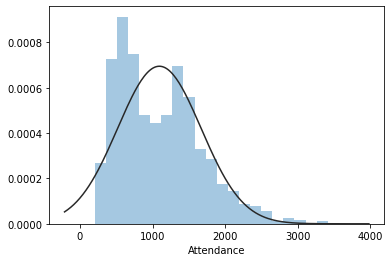

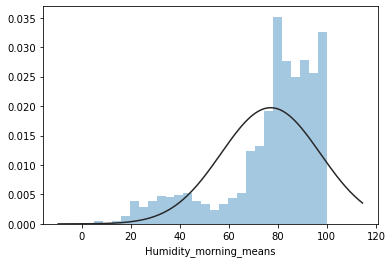

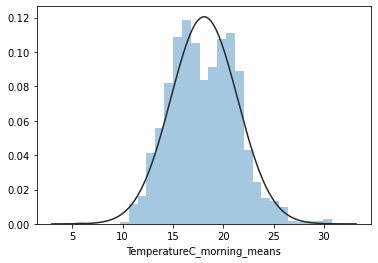

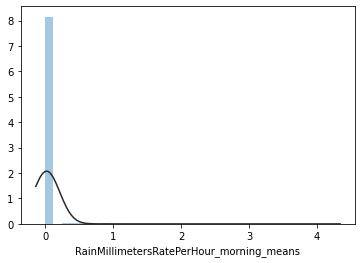

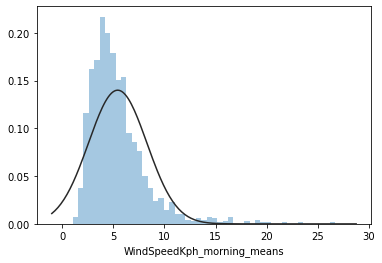

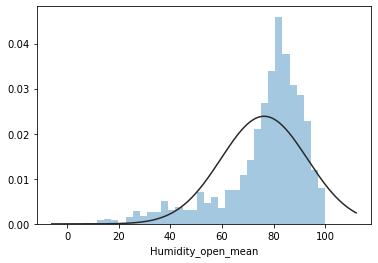

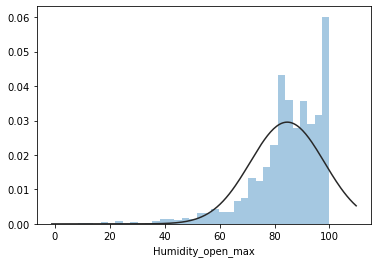

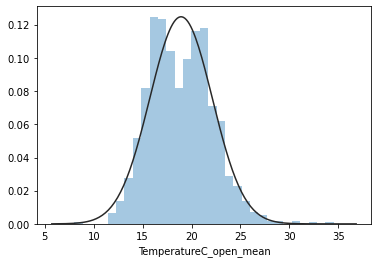

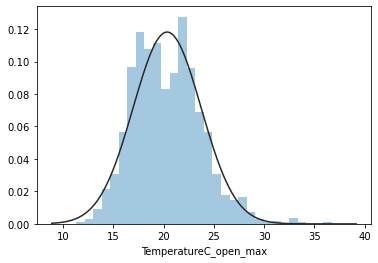

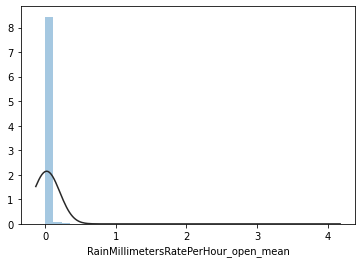

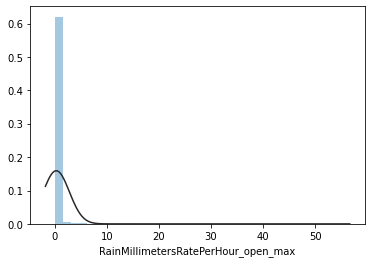

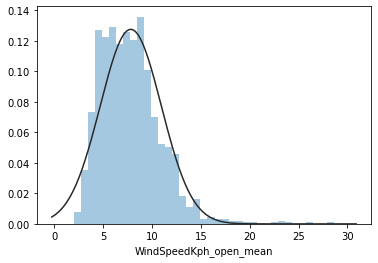

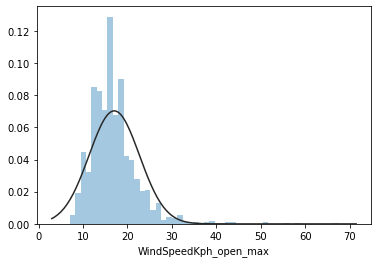

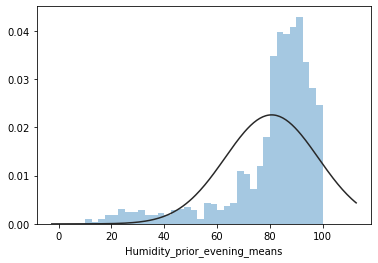

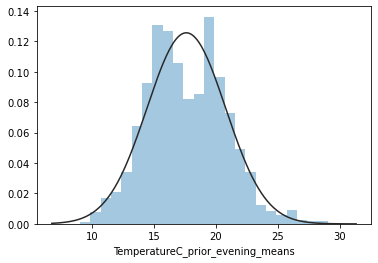

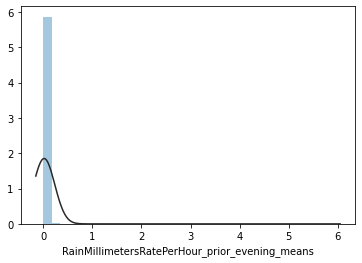

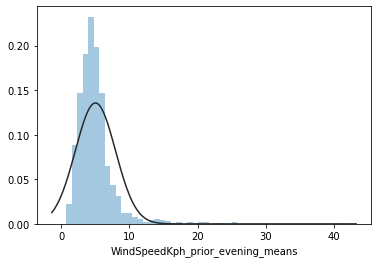

In [142]:
for col in plot_columns:
    create_box_and_dist_plots(model_building[col])

In [143]:
plt.close('all')

In [144]:
model_building.loc[(model_building.Attendance > 1300) & (model_building.Attendance < 1500) & (model_building.WinterBreak == 1)]

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,61.001418,10.679627,0.000000,5.830220,62.310442,69.511897,13.091680,14.092484,0.000000,0.000,5.387012,13.405793,63.680582,10.207602,0.000000,8.721284,1415.0,17.0,0.0,0,NaN,2903.0,3131.0,2010.0,1940.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2231.714286,977.740741,785.500000,NaN,NaN
2015-01-04,62.406223,13.257449,0.000000,4.319221,66.450297,70.625747,15.001633,16.561002,0.000000,0.000,6.168265,14.464145,74.211219,12.401153,0.000000,5.605346,1337.0,20.0,0.0,0,2222.0,1415.0,NaN,2903.0,2006.0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2146.285714,1058.592593,783.250000,NaN,NaN
2015-01-10,63.638972,16.603810,0.000000,2.146103,65.475693,73.327866,17.174472,18.968627,0.000000,0.000,3.763030,11.289089,96.345476,14.761566,0.000000,1.954312,1306.0,13.0,0.0,0,541.0,548.0,572.0,473.0,2222.0,...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,934.000000,1113.888889,782.000000,NaN,NaN
2015-01-24,23.124042,20.128131,0.000000,7.684971,14.155254,52.175022,24.479828,27.029956,0.000000,0.000,11.034503,28.928291,40.201629,15.960456,0.000000,5.655925,1404.0,0.0,256.0,0,506.0,405.0,373.0,373.0,1176.0,...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,840.750000,1135.857143,551.500000,NaN,NaN
2015-12-22,100.000000,15.189643,0.000000,26.693992,100.000000,100.000000,15.062279,15.436819,0.000000,0.000,23.467194,40.922948,85.344582,13.974172,0.000000,4.426871,1475.0,18.0,0.0,0,899.0,823.0,906.0,302.0,218.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,648.625000,716.892857,1558.750000,552.000000,607.607143
2016-01-03,71.272786,13.701232,0.000000,8.094434,74.030799,81.125779,15.181585,16.902941,0.000000,0.000,8.922496,20.108690,77.962930,12.381176,0.000000,4.210275,1481.0,0.0,0.0,0,2742.0,NaN,1847.0,2196.0,2389.0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2404.714286,1158.962963,1343.750000,2268.166667,1009.080000
2016-01-09,75.725392,12.219496,0.000000,7.477062,75.352298,82.584183,13.825112,15.872440,0.000000,0.000,6.859690,16.580850,85.596310,11.139086,0.000000,7.021540,1314.0,43.0,0.0,0,581.0,833.0,663.0,947.0,2742.0,...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1156.625000,1249.444444,1158.250000,934.000000,1068.800000
2016-01-10,90.770376,12.587779,0.000000,4.836855,90.349306,96.090743,13.912003,15.563290,0.000000,0.000,3.783429,11.641873,85.706024,13.011213,0.000000,3.943215,1360.0,0.0,0.0,0,1314.0,581.0,833.0,663.0,1481.0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,983.875000,1263.000000,1145.000000,875.750000,1104.440000
2016-01-17,89.141296,15.389258,0.000000,6.087786,86.823630,96.700225,16.274548,19.591612,0.000000,0.000,6.986579,29.986643,96.265244,14.433330,0.000000,4.633230,1346.0,20.0,0.0,0,1196.0,565.0,364.0,421.0,1360.0,...,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,746.750000,1315.814815,694.500000,752.875000,1154.920000


C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

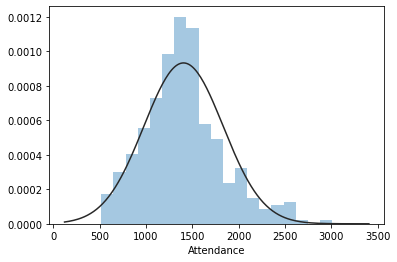

In [145]:
sns.distplot(model_building.loc[(model_building.SummerBreak == 1, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

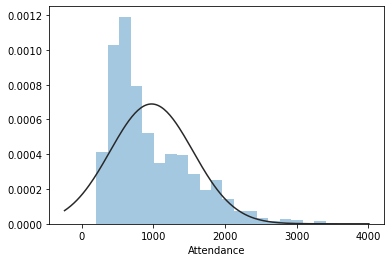

In [146]:
sns.distplot(model_building.loc[(model_building.SummerBreak == 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

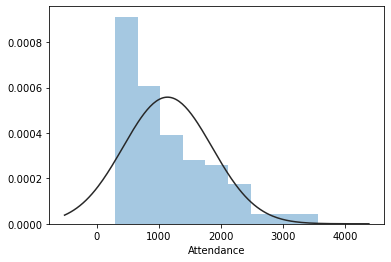

In [147]:
sns.distplot(model_building.loc[(model_building.WinterBreak == 1, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

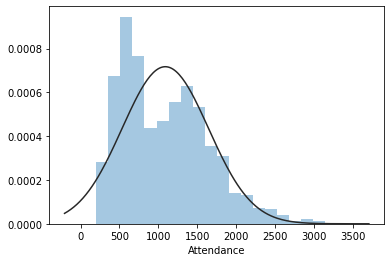

In [148]:
sns.distplot(model_building.loc[(model_building.WinterBreak == 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

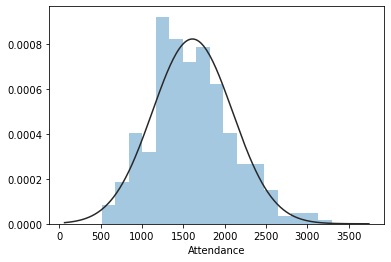

In [149]:
sns.distplot(model_building.loc[(model_building.Weekend == 1, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

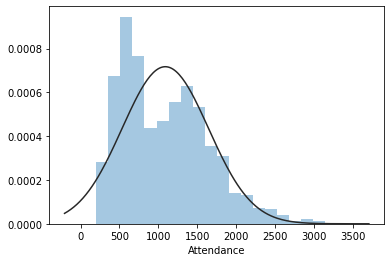

In [150]:
sns.distplot(model_building.loc[(model_building.WinterBreak == 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

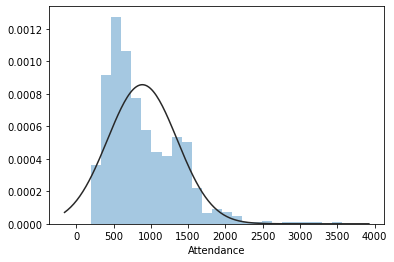

In [151]:
sns.distplot(model_building.loc[(model_building.BusinessDay == 1, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

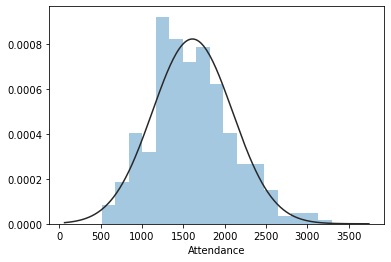

In [152]:
sns.distplot(model_building.loc[(model_building.BusinessDay == 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Humidity_morning_means'>

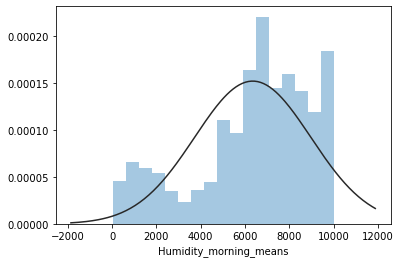

In [153]:
sns.distplot(model_building.Humidity_morning_means*model_building.Humidity_morning_means, kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

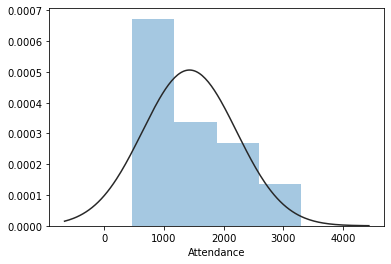

In [154]:
sns.distplot(model_building.loc[(model_building.RainMillimetersRatePerHour_morning_means > 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

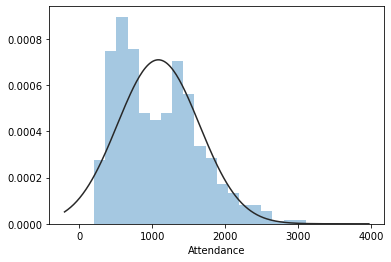

In [155]:
sns.distplot(model_building.loc[(model_building.RainMillimetersRatePerHour_morning_means == 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

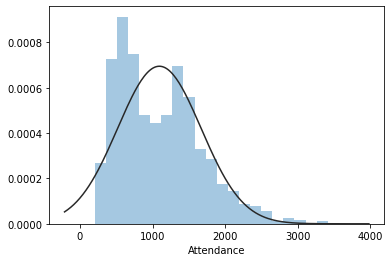

In [156]:
sns.distplot(model_building.loc[(model_building.WindSpeedKph_morning_means > 0, 'Attendance')], kde=False, fit=stats.norm)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Attendance'>

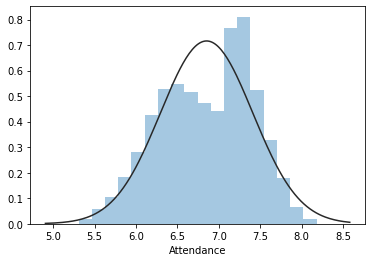

In [157]:
sns.distplot(np.log(model_building.Attendance), kde=False, fit=stats.norm)

In [158]:
def create_scatter_plots(col, lowess_arg = True, order_arg=1):
    plt.figure()
    sns.regplot(x=col, y='Attendance', data=model_building, lowess=lowess_arg, order=order_arg, ci=None, truncate=True, line_kws={'color':'black'})

In [159]:
plot_columns2 = ['Humidity_morning_means','TemperatureC_morning_means', 'RainMillimetersRatePerHour_morning_means', 'WindSpeedKph_morning_means', 'Humidity_open_mean', 'Humidity_open_max', 'TemperatureC_open_mean', 'TemperatureC_open_max', 'RainMillimetersRatePerHour_open_mean', 'RainMillimetersRatePerHour_open_max', 'WindSpeedKph_open_mean', 'WindSpeedKph_open_max', 'Humidity_prior_evening_means', 'TemperatureC_prior_evening_means', 'RainMillimetersRatePerHour_prior_evening_means', 'WindSpeedKph_prior_evening_means']

C:\Users\shani\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\shani\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\shani\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\shani\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


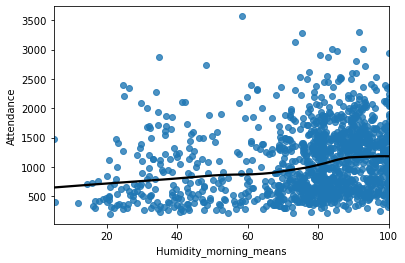

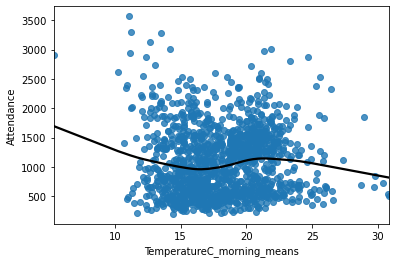

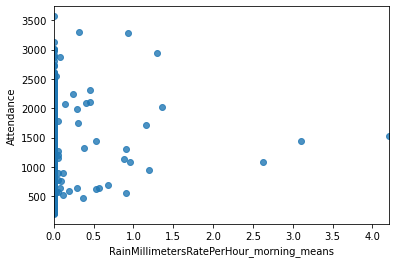

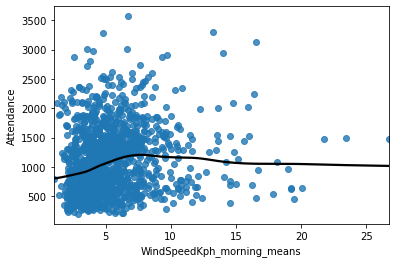

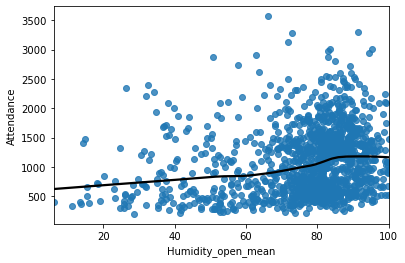

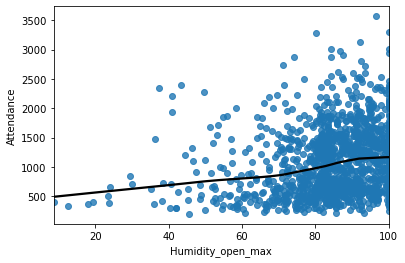

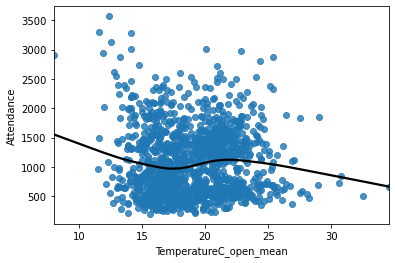

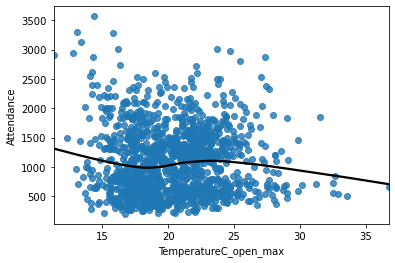

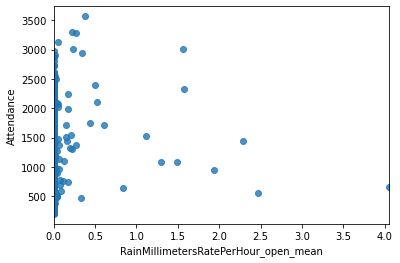

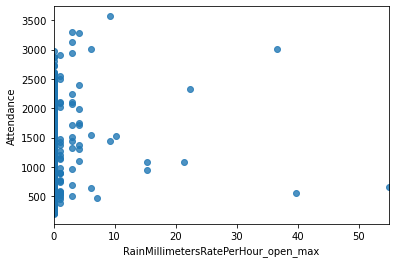

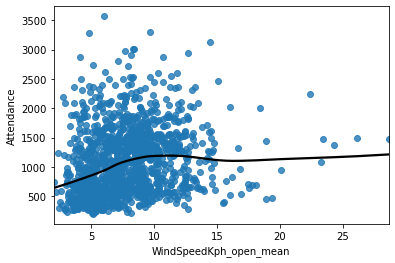

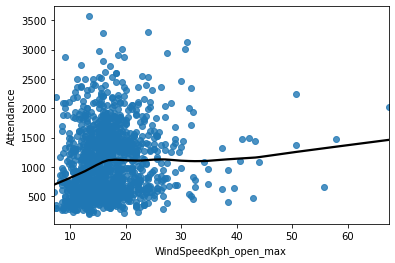

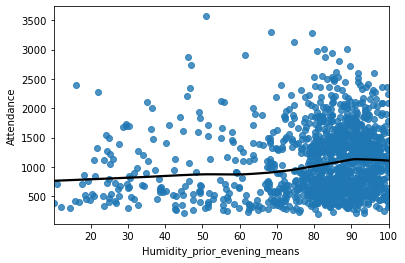

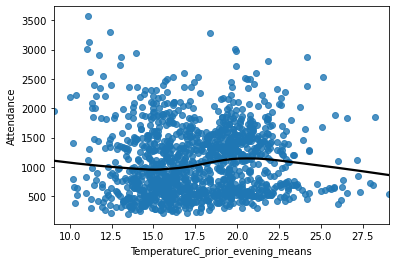

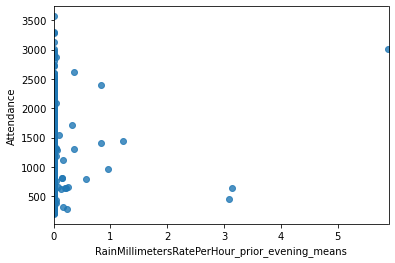

In [160]:
for col in plot_columns2:
    create_scatter_plots(col)
plt.close()

In [161]:
model_building['Humidity_morning_means_Log'] = np.log(model_building.Humidity_morning_means)

<ipython-input-161-e64ef4f2bf6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Humidity_morning_means_Log'] = np.log(model_building.Humidity_morning_means)


C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


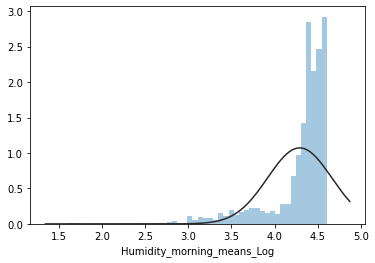

In [162]:
create_box_and_dist_plots(model_building.Humidity_morning_means_Log)

In [163]:
plt.close('all')

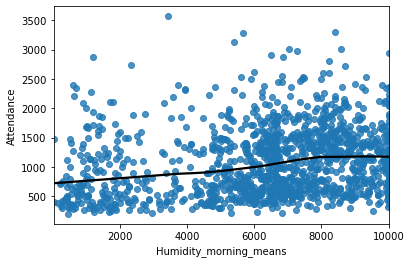

In [164]:
create_scatter_plots(model_building.Humidity_morning_means*model_building.Humidity_morning_means)

In [165]:
model_building['Humidity_morning_means_squared'] = model_building.Humidity_morning_means*model_building.Humidity_morning_means

<ipython-input-165-face37f1f375>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Humidity_morning_means_squared'] = model_building.Humidity_morning_means*model_building.Humidity_morning_means


In [166]:
model_building

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo,Humidity_morning_means_Log,Humidity_morning_means_squared
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-01,88.554669,19.047877,0.0,3.832951,82.781628,90.128443,19.782733,20.687691,0.0,0.0,7.691427,16.228066,86.871634,18.795550,0.0,4.856660,1212.0,72.0,0.0,0,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1212.000000,1212.000000,1212.0,NaN,NaN,4.483620,7841.929448
2014-07-02,90.988468,18.634756,0.0,6.987084,86.884762,91.665144,19.405419,20.561220,0.0,0.0,9.051115,16.580850,86.871634,18.795550,0.0,4.856660,1601.0,57.0,0.0,0,1212.0,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1406.500000,1406.500000,1406.5,NaN,NaN,4.510733,8278.901367
2014-07-03,85.146220,19.786319,0.0,5.425246,81.707528,84.693265,20.573272,22.032026,0.0,0.0,8.437418,15.169714,86.848600,18.778063,0.0,4.815502,1183.0,8.0,0.0,0,1601.0,1212.0,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1332.000000,1332.000000,1332.0,NaN,NaN,4.444370,7249.878803
2014-07-04,88.832017,20.048755,0.0,7.589624,84.352488,89.746846,20.593565,21.779085,0.0,0.0,8.819601,15.522498,86.148304,19.503382,0.0,5.332244,968.0,0.0,425.0,0,1183.0,1601.0,1212.0,NaN,NaN,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1241.000000,1241.000000,1241.0,NaN,NaN,4.486747,7891.127226
2014-07-05,86.183556,21.592892,0.0,4.860580,81.108811,87.467578,22.473502,23.966558,0.0,0.0,6.401560,12.700225,83.445171,20.570972,0.0,3.678207,2499.0,25.0,16.0,BofA in prepaid,968.0,1183.0,1601.0,1212.0,NaN,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1492.600000,1492.600000,1242.5,NaN,NaN,4.456479,7427.605331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,93.157236,14.710004,0.0,2.459689,83.300162,100.000000,16.468834,17.633660,0.0,0.0,3.595546,8.819601,98.184564,13.867726,0.0,3.551758,2095.0,55.0,0.0,0,1887.0,NaN,1000.0,1140.0,648.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1217.142857,708.357143,1447.0,1500.500000,736.333333,4.534289,8678.270689
2017-12-28,62.772002,16.207290,0.0,2.316933,74.304382,88.844248,17.020793,18.476797,0.0,0.0,4.254575,13.053009,95.810258,14.497033,0.0,2.275457,2317.0,28.0,0.0,Holiday Bowl,2095.0,1887.0,NaN,1000.0,760.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1455.571429,779.285714,1849.0,1688.000000,802.518519,4.139509,3940.324178
2017-12-29,29.795642,19.281476,0.0,1.281163,38.024376,71.830009,20.128158,22.069499,0.0,0.0,2.931381,9.172385,84.831664,14.986328,0.0,2.788674,2097.0,0.0,0.0,0,2317.0,2095.0,1887.0,NaN,990.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1646.571429,840.750000,1756.5,1993.666667,912.000000,3.394362,887.780261


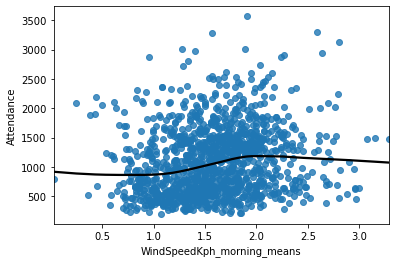

In [167]:
create_scatter_plots(np.log(model_building.WindSpeedKph_morning_means))

In [168]:
model_building['WindSpeedKph_morning_means_Log'] = np.log(model_building.WindSpeedKph_morning_means)

<ipython-input-168-7c8682751ba5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['WindSpeedKph_morning_means_Log'] = np.log(model_building.WindSpeedKph_morning_means)


In [169]:
model_building['Has_Rain_Morning'] = np.where(model_building.RainMillimetersRatePerHour_morning_means == 0, 0, 1)

<ipython-input-169-ecc3b3202b3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Has_Rain_Morning'] = np.where(model_building.RainMillimetersRatePerHour_morning_means == 0, 0, 1)


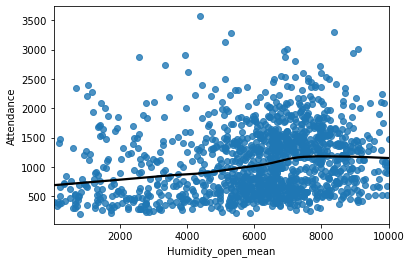

In [170]:
create_scatter_plots(model_building.Humidity_open_mean*model_building.Humidity_open_mean)

In [171]:
model_building['Humidity_open_mean_squared'] = model_building.Humidity_open_mean*model_building.Humidity_open_mean

<ipython-input-171-ea94705f4f83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Humidity_open_mean_squared'] = model_building.Humidity_open_mean*model_building.Humidity_open_mean


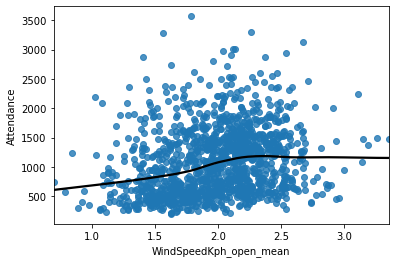

In [172]:
create_scatter_plots(np.log(model_building.WindSpeedKph_open_mean))

In [173]:
model_building['WindSpeedKph_open_mean_Log'] = np.log(model_building.WindSpeedKph_open_mean)

<ipython-input-173-263a10e4fab4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['WindSpeedKph_open_mean_Log'] = np.log(model_building.WindSpeedKph_open_mean)


In [174]:
model_building['Has_Rain_Open'] = np.where(model_building.RainMillimetersRatePerHour_open_mean == 0, 0, 1)

<ipython-input-174-a809f1d956f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Has_Rain_Open'] = np.where(model_building.RainMillimetersRatePerHour_open_mean == 0, 0, 1)


In [175]:
model_results = sm.ols(formula= 'Attendance ~ DailyAttendancePrevDay + DailyAttendancePrev2Days + DailyAttendancePrev3Days + DailyAttendancePrev4Days + DailyAttendancePrev7Days + DailyAttendanceSameDayofWeekPrevYear + AvgDailyAttendancePrev7Days + AvgDailyAttendancePrev28Days + Prior_Weekend_And_Businessday + AvgWeeklyAttendanceAYearAgo + AvgMonthlyAttendanceAYearAgo', data=model_building).fit()

In [176]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     276.7
Date:                Tue, 26 Oct 2021   Prob (F-statistic):          1.59e-271
Time:                        18:58:52   Log-Likelihood:                -6002.8
No. Observations:                 859   AIC:                         1.203e+04
Df Residuals:                     847   BIC:                         1.209e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               73.5671     46.082      1.596      0.111     -16.880     164.015
DailyAttendancePrevDay                   0.1645      0.027      6.098      0.000       0.112       0.217
DailyAttendancePrev2Days                -0.3089      0.030    -10.194      0.000      -0.368      -0.249
DailyAttendancePrev3Days                -0.0278      0.028     -1.003      0.316      -0.082       0.027
DailyAttendancePrev4Days                -0.3428      0.030    -11.513      0.000      -0.401      -0.284
DailyAttendancePrev7Days                -0.1237      0.030     -4.124      0.000      -0.183      -0.065
DailyAttendanceSameDayofWeekPrevYear     0.4471      0.028     15.749      0.000       0.391       0.503
AvgDailyAttendancePrev7Days              1.5039      0.101     14.905      0.000       1.306       1.702
AvgDailyAttendancePrev28Days             0.0342      0.094      0.364      0.716      -0.150       0.219
Prior_Weekend_And_Businessday           -0.0443      0.021     -2.066      0.039      -0.086      -0.002
AvgWeeklyAttendanceAYearAgo             -0.2386      0.072     -3.310      0.001      -0.380      -0.097
AvgMonthlyAttendanceAYearAgo            -0.1331      0.096     -1.382      0.167      -0.322       0.056
==============================================================================
Omnibus:                       85.476   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.370
Skew:                           0.451   Prob(JB):                     4.83e-62
Kurtosis:                       5.660   Cond. No.                     1.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
model_results1 = sm.ols(formula= 'Attendance ~ DailyAttendancePrevDay + DailyAttendancePrev2Days + DailyAttendancePrev3Days + DailyAttendancePrev4Days + DailyAttendancePrev7Days + DailyAttendanceSameDayofWeekPrevYear + AvgDailyAttendancePrev7Days + AvgDailyAttendancePrev28Days + Humidity_morning_means_squared + TemperatureC_morning_means + WindSpeedKph_morning_means_Log + AvgWeeklyAttendanceAYearAgo:Monday + AvgWeeklyAttendanceAYearAgo:Tuesday + AvgWeeklyAttendanceAYearAgo:Wednesday + AvgWeeklyAttendanceAYearAgo:Thursday + AvgWeeklyAttendanceAYearAgo:Friday + AvgWeeklyAttendanceAYearAgo:Saturday + AvgWeeklyAttendanceAYearAgo:Sunday + Prior_Weekend_And_Businessday:Weekend + Prior_Weekend_And_Businessday:BusinessDay + AvgMonthlyAttendanceAYearAgo:January + AvgMonthlyAttendanceAYearAgo:February + AvgMonthlyAttendanceAYearAgo:March + AvgMonthlyAttendanceAYearAgo:April + AvgMonthlyAttendanceAYearAgo:May + AvgMonthlyAttendanceAYearAgo:June + AvgMonthlyAttendanceAYearAgo:July + AvgMonthlyAttendanceAYearAgo:August + AvgMonthlyAttendanceAYearAgo:September + AvgMonthlyAttendanceAYearAgo:October + AvgMonthlyAttendanceAYearAgo:November + AvgMonthlyAttendanceAYearAgo:December + AvgWeeklyAttendanceAYearAgo:SpecialEventDay + AvgWeeklyAttendanceAYearAgo:Holidays + AvgWeeklyAttendanceAYearAgo:WinterBreak + AvgWeeklyAttendanceAYearAgo:SummerBreak', data=model_building).fit()

In [178]:
model_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     124.2
Date:                Tue, 26 Oct 2021   Prob (F-statistic):          2.48e-304
Time:                        18:58:54   Log-Likelihood:                -5857.8
No. Observations:                 859   AIC:                         1.179e+04
Df Residuals:                     822   BIC:                         1.197e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      24.8068    131.398      0.189      0.850    -233.109     282.723
DailyAttendancePrevDay                          0.0686      0.033      2.082      0.038       0.004       0.133
DailyAttendancePrev2Days                       -0.2601      0.032     -8.119      0.000      -0.323      -0.197
DailyAttendancePrev3Days                       -0.2130      0.033     -6.432      0.000      -0.278      -0.148
DailyAttendancePrev4Days                       -0.4612      0.035    -13.189      0.000      -0.530      -0.393
DailyAttendancePrev7Days                       -0.3471      0.033    -10.572      0.000      -0.412      -0.283
DailyAttendanceSameDayofWeekPrevYear            0.2171      0.029      7.609      0.000       0.161       0.273
AvgDailyAttendancePrev7Days                     2.0103      0.114     17.632      0.000       1.786       2.234
AvgDailyAttendancePrev28Days                    0.0309      0.097      0.318      0.751      -0.160       0.222
Humidity_morning_means_squared                  0.0076      0.004      1.809      0.071      -0.001       0.016
TemperatureC_morning_means                      3.1098      4.006      0.776      0.438      -4.753      10.973
WindSpeedKph_morning_means_Log                 47.1216     18.341      2.569      0.010      11.121      83.122
AvgWeeklyAttendanceAYearAgo:Monday             -0.2691      0.072     -3.728      0.000      -0.411      -0.127
AvgWeeklyAttendanceAYearAgo:Tuesday            -0.1300      0.072     -1.808      0.071      -0.271       0.011
AvgWeeklyAttendanceAYearAgo:Wednesday           0.0147      0.073      0.202      0.840      -0.128       0.158
AvgWeeklyAttendanceAYearAgo:Thursday           -0.1525      0.072     -2.110      0.035      -0.294      -0.011
AvgWeeklyAttendanceAYearAgo:Friday             -0.3713      0.071     -5.230      0.000      -0.511      -0.232
AvgWeeklyAttendanceAYearAgo:Saturday            0.0505      0.074      0.682      0.495      -0.095       0.196
AvgWeeklyAttendanceAYearAgo:Sunday             -0.0101      0.074     -0.136      0.892      -0.156       0.136
Prior_Weekend_And_Businessday:Weekend           0.0396      0.031      1.287      0.198      -0.021       0.100
Prior_Weekend_And_Businessday:BusinessDay      -0.0742      0.022     -3.371      0.001      -0.117      -0.031
AvgMonthlyAttendanceAYearAgo:January           -0.0673      0.109     -0.620      0.536      -0.280       0.146
AvgMonthlyAttendanceAYearAgo:February          -0.0482      0.120     -0.401      0.689      -0.285       0.188
AvgMonthlyAttendanceAYearAgo:March             -0.0361      0.104     -0.346      0.730      -0.241       0.169
AvgMonthlyAttendanceAYearAgo:April             -0.0642     

In [179]:
model_results2 = sm.ols(formula= 'Attendance ~ DailyAttendancePrevDay + DailyAttendancePrev4Days + Humidity_morning_means_squared + TemperatureC_morning_means + WindSpeedKph_morning_means_Log + AvgWeeklyAttendanceAYearAgo:Monday + AvgWeeklyAttendanceAYearAgo:Tuesday + AvgWeeklyAttendanceAYearAgo:Wednesday + AvgWeeklyAttendanceAYearAgo:Thursday + AvgWeeklyAttendanceAYearAgo:Friday + AvgWeeklyAttendanceAYearAgo:Saturday + AvgWeeklyAttendanceAYearAgo:Sunday + Prior_Weekend_And_Businessday:Weekend + Prior_Weekend_And_Businessday:BusinessDay + AvgMonthlyAttendanceAYearAgo:January + AvgMonthlyAttendanceAYearAgo:February + AvgMonthlyAttendanceAYearAgo:March + AvgMonthlyAttendanceAYearAgo:April + AvgMonthlyAttendanceAYearAgo:May + AvgMonthlyAttendanceAYearAgo:June + AvgMonthlyAttendanceAYearAgo:July + AvgMonthlyAttendanceAYearAgo:August + AvgMonthlyAttendanceAYearAgo:September + AvgMonthlyAttendanceAYearAgo:October + AvgMonthlyAttendanceAYearAgo:November + AvgMonthlyAttendanceAYearAgo:December + AvgWeeklyAttendanceAYearAgo:SpecialEventDay + AvgWeeklyAttendanceAYearAgo:Holidays + AvgWeeklyAttendanceAYearAgo:WinterBreak + AvgWeeklyAttendanceAYearAgo:SummerBreak + RainMillimetersRatePerHour_morning_means:Has_Rain_Morning', data=model_building).fit()

In [180]:
model_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     77.81
Date:                Tue, 26 Oct 2021   Prob (F-statistic):          4.91e-225
Time:                        18:58:57   Log-Likelihood:                -6315.4
No. Observations:                 889   AIC:                         1.269e+04
Df Residuals:                     857   BIC:                         1.285e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   378.3455    163.429      2.315      0.021      57.578     699.113
DailyAttendancePrevDay                                        0.4218      0.031     13.726      0.000       0.362       0.482
DailyAttendancePrev4Days                                     -0.1427      0.029     -4.912      0.000      -0.200      -0.086
Humidity_morning_means_squared                                0.0091      0.005      1.719      0.086      -0.001       0.020
TemperatureC_morning_means                                    6.0347      5.060      1.193      0.233      -3.897      15.967
WindSpeedKph_morning_means_Log                               57.3266     24.016      2.387      0.017      10.190     104.463
AvgWeeklyAttendanceAYearAgo:Monday                            0.0536      0.079      0.682      0.495      -0.101       0.208
AvgWeeklyAttendanceAYearAgo:Tuesday                           0.2554      0.074      3.475      0.001       0.111       0.400
AvgWeeklyAttendanceAYearAgo:Wednesday                         0.4024      0.079      5.109      0.000       0.248       0.557
AvgWeeklyAttendanceAYearAgo:Thursday                          0.3874      0.078      4.939      0.000       0.233       0.541
AvgWeeklyAttendanceAYearAgo:Friday                            0.3869      0.073      5.331      0.000       0.244       0.529
AvgWeeklyAttendanceAYearAgo:Saturday                          0.7294      0.073      9.964      0.000       0.586       0.873
AvgWeeklyAttendanceAYearAgo:Sunday                            0.4379      0.077      5.717      0.000       0.288       0.588
Prior_Weekend_And_Businessday:Weekend                         0.0890      0.037      2.395      0.017       0.016       0.162
Prior_Weekend_And_Businessday:BusinessDay                    -0.0916      0.028     -3.217      0.001      -0.147      -0.036
AvgMonthlyAttendanceAYearAgo:January                         -0.3976      0.118     -3.378      0.001      -0.629      -0.167
AvgMonthlyAttendanceAYearAgo:February                        -0.1994      0.150     -1.330      0.184      -0.494       0.095
AvgMonthlyAttendanceAYearAgo:March                           -0.1373      0.123     -1.113      0.266      -0.379       0.105
AvgMonthlyAttendanceAYearAgo:April                           -0.1400      0.107     -1.310      0.191      -0.350       0.070
AvgMonthlyAttendanceAYearAgo:May                             -0.2380      0.137     -1.739      0.082      -0.507       0.031
AvgMonthlyAttendanceAYearAgo:June                            -0.2970      0.142     -2.086      0.037      -0.576      -0.018
AvgMonthlyAttendanceAYearAgo:July                          

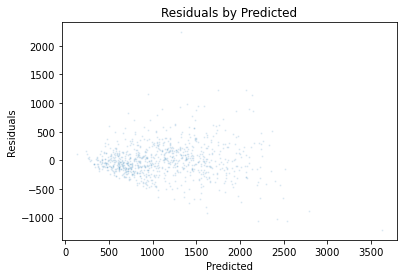

In [181]:
#### RESIDUAL ANALYSIS ####
## Heteroscedasticity and Uncorrelated Errors
plt.figure()
plt.title("Residuals by Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.scatter(model_results2.fittedvalues,model_results2.resid, s=1, alpha=0.1)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

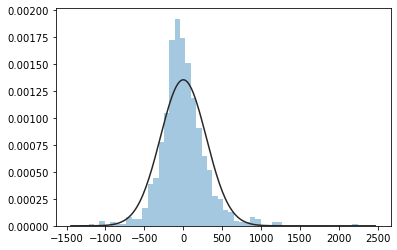

In [182]:
## Normally Distributed Errors ##
plt.figure()
sns.distplot(model_results2.resid, kde=False, fit=stats.norm)

In [183]:
plt.close('all')

<ipython-input-184-dbceeb783138>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building["residuals"] = model_results.resid
<ipython-input-184-dbceeb783138>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building["predicted"] = model_results.fittedvalues


<Figure size 432x288 with 0 Axes>

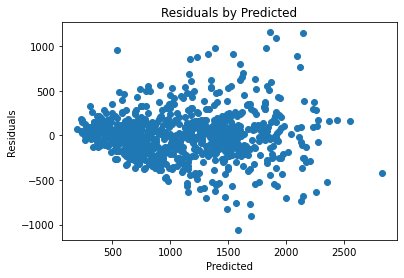

<Figure size 432x288 with 0 Axes>

In [184]:
# i Residuals by Predicted
model_building["residuals"] = model_results.resid
model_building["predicted"] = model_results.fittedvalues
plt.scatter(model_building.predicted, model_building.residuals)
plt.title("Residuals by Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.figure()

In [185]:
model_building["CooksD"] = model_results2.get_influence().summary_frame().filter(["cooks_d"])

<ipython-input-185-e93472ab9c89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building["CooksD"] = model_results2.get_influence().summary_frame().filter(["cooks_d"])


In [186]:
model_building = model_building[(model_building.CooksD<(4/model_building.residuals.count()))]

In [187]:
model_building

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo,Humidity_morning_means_Log,Humidity_morning_means_squared,WindSpeedKph_morning_means_Log,Has_Rain_Morning,Humidity_open_mean_squared,WindSpeedKph_open_mean_Log,Has_Rain_Open,residuals,predicted,CooksD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-06-30,95.449493,20.085215,0.0,5.654079,94.039800,97.668867,20.355892,22.528540,0.0,0.0,7.463019,21.167042,95.538712,19.189548,0.0,2.793356,1270.0,360.0,0.0,0,1289.0,1664.0,1849.0,1353.0,1171.0,...,0,0,0,0,0,0,0,0,0,1,1367.000,1173.137931,517.00,1212.000000,1212.000000,4.558597,9110.605663,1.732377,0,8843.483955,2.009960,0,-6.086799,1276.086799,0.000311
2015-07-01,99.707374,20.835430,0.0,4.710144,97.889732,100.000000,21.126227,22.186601,0.0,0.0,7.530859,13.758577,96.307889,20.685349,0.0,4.512222,1441.0,105.0,0.0,0,1270.0,1289.0,1664.0,1849.0,1172.0,...,1,0,0,0,0,0,0,0,0,1,1400.750,1201.172414,651.75,1406.500000,1406.500000,4.602240,9941.560504,1.549718,0,9582.399612,2.019009,0,69.848265,1371.151735,0.000038
2015-07-02,100.000000,19.645609,0.0,5.115369,95.148763,100.000000,20.954445,22.434858,0.0,0.0,7.959240,18.344770,99.483983,19.930680,0.0,4.745514,1448.0,123.0,0.0,0,1441.0,1270.0,1289.0,1664.0,1168.0,...,1,0,0,0,0,0,0,0,0,1,1435.250,1226.448276,905.25,1332.000000,1332.000000,4.605170,10000.000000,1.632249,0,9053.287028,2.074333,0,86.191783,1361.808217,0.000016
2015-07-03,91.694387,19.557351,0.0,3.648795,86.873585,94.545271,20.171503,21.282571,0.0,0.0,8.860450,17.639202,93.768609,19.547459,0.0,4.291242,2023.0,27.0,103.0,0,1448.0,1441.0,1270.0,1289.0,1353.0,...,1,0,0,0,0,0,1,1,0,1,1542.125,1267.068966,1353.25,1241.000000,1241.000000,4.518461,8407.860536,1.294397,0,7547.019855,2.181598,0,526.698158,1496.301842,0.003174
2015-07-05,89.859141,18.630233,0.0,4.948511,93.372617,99.334059,18.628505,19.376144,0.0,0.0,8.150031,15.522498,95.514982,17.814036,0.0,6.402163,2265.0,55.0,0.0,BofA in prepaid,1392.0,2023.0,1448.0,1441.0,1664.0,...,1,0,0,0,0,0,0,0,0,1,1599.000,1306.413793,937.00,1615.333333,1615.333333,4.498243,8074.665213,1.599087,0,8718.445628,2.098022,0,523.234202,1741.765798,0.004092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-20,75.546415,14.548740,0.0,3.279938,78.668680,86.160794,14.747206,16.195643,0.0,0.0,7.844045,23.636530,86.703466,13.825044,0.0,3.998219,648.0,140.0,0.0,0,658.0,598.0,786.0,818.0,298.0,...,0,0,0,0,0,1,0,0,1,0,545.750,663.178571,1426.00,679.750000,645.250000,4.324747,5707.260793,1.187825,0,6188.761152,2.059755,0,44.268818,603.731182,0.000026
2017-12-21,60.382971,12.195172,0.0,5.415712,37.670600,68.370066,14.538337,15.849020,0.0,0.0,6.699472,13.758577,91.926683,12.804818,0.0,8.518867,760.0,24.0,0.0,0,648.0,658.0,598.0,786.0,284.0,...,0,0,0,0,0,1,0,0,1,0,603.500,647.214286,1740.00,812.875000,657.392857,4.100707,3646.103242,1.689304,0,1419.074072,1.902029,0,-114.755288,874.755288,0.000007
2017-12-22,31.931262,12.514830,0.0,3.604118,39.939527,54.758674,14.728716,16.256536,0.0,0.0,5.117150,16.228066,32.36

In [188]:
model_results2_outliers_data_removed = sm.ols(formula= 'Attendance ~ DailyAttendancePrevDay + DailyAttendancePrev4Days + Humidity_morning_means_squared + TemperatureC_morning_means + WindSpeedKph_morning_means_Log + AvgWeeklyAttendanceAYearAgo:Monday + AvgWeeklyAttendanceAYearAgo:Tuesday + AvgWeeklyAttendanceAYearAgo:Wednesday + AvgWeeklyAttendanceAYearAgo:Thursday + AvgWeeklyAttendanceAYearAgo:Friday + AvgWeeklyAttendanceAYearAgo:Saturday + AvgWeeklyAttendanceAYearAgo:Sunday + Prior_Weekend_And_Businessday:Weekend + Prior_Weekend_And_Businessday:BusinessDay + AvgMonthlyAttendanceAYearAgo:January + AvgMonthlyAttendanceAYearAgo:February + AvgMonthlyAttendanceAYearAgo:March + AvgMonthlyAttendanceAYearAgo:April + AvgMonthlyAttendanceAYearAgo:May + AvgMonthlyAttendanceAYearAgo:June + AvgMonthlyAttendanceAYearAgo:July + AvgMonthlyAttendanceAYearAgo:August + AvgMonthlyAttendanceAYearAgo:September + AvgMonthlyAttendanceAYearAgo:October + AvgMonthlyAttendanceAYearAgo:November + AvgMonthlyAttendanceAYearAgo:December + AvgWeeklyAttendanceAYearAgo:SpecialEventDay + AvgWeeklyAttendanceAYearAgo:Holidays + AvgWeeklyAttendanceAYearAgo:WinterBreak + AvgWeeklyAttendanceAYearAgo:SummerBreak + RainMillimetersRatePerHour_morning_means:Has_Rain_Morning', data=model_building).fit()

In [189]:
model_results2_outliers_data_removed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     132.5
Date:                Tue, 26 Oct 2021   Prob (F-statistic):          7.32e-291
Time:                        18:59:29   Log-Likelihood:                -5640.0
No. Observations:                 833   AIC:                         1.134e+04
Df Residuals:                     801   BIC:                         1.150e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   266.4099    122.938      2.167      0.031      25.092     507.728
DailyAttendancePrevDay                                        0.4546      0.026     17.348      0.000       0.403       0.506
DailyAttendancePrev4Days                                     -0.0805      0.022     -3.671      0.000      -0.124      -0.037
Humidity_morning_means_squared                                0.0038      0.004      0.965      0.335      -0.004       0.012
TemperatureC_morning_means                                    7.1261      3.765      1.893      0.059      -0.265      14.517
WindSpeedKph_morning_means_Log                               41.2910     18.422      2.241      0.025       5.129      77.453
AvgWeeklyAttendanceAYearAgo:Monday                           -0.0560      0.060     -0.927      0.354      -0.175       0.063
AvgWeeklyAttendanceAYearAgo:Tuesday                           0.2308      0.055      4.161      0.000       0.122       0.340
AvgWeeklyAttendanceAYearAgo:Wednesday                         0.2751      0.060      4.573      0.000       0.157       0.393
AvgWeeklyAttendanceAYearAgo:Thursday                          0.2739      0.060      4.579      0.000       0.156       0.391
AvgWeeklyAttendanceAYearAgo:Friday                            0.2936      0.055      5.321      0.000       0.185       0.402
AvgWeeklyAttendanceAYearAgo:Saturday                          0.6601      0.056     11.830      0.000       0.551       0.770
AvgWeeklyAttendanceAYearAgo:Sunday                            0.3371      0.059      5.682      0.000       0.221       0.453
Prior_Weekend_And_Businessday:Weekend                         0.1309      0.028      4.724      0.000       0.077       0.185
Prior_Weekend_And_Businessday:BusinessDay                    -0.0619      0.021     -2.933      0.003      -0.103      -0.020
AvgMonthlyAttendanceAYearAgo:January                         -0.2943      0.090     -3.286      0.001      -0.470      -0.119
AvgMonthlyAttendanceAYearAgo:February                        -0.1237      0.116     -1.065      0.287      -0.352       0.104
AvgMonthlyAttendanceAYearAgo:March                           -0.0330      0.094     -0.351      0.725      -0.217       0.151
AvgMonthlyAttendanceAYearAgo:April                           -0.0864      0.081     -1.062      0.289      -0.246       0.073
AvgMonthlyAttendanceAYearAgo:May                             -0.1724      0.105     -1.646      0.100      -0.378       0.033
AvgMonthlyAttendanceAYearAgo:June                            -0.2569      0.110     -2.342      0.019      -0.472      -0.042
AvgMonthlyAttendanceAYearAgo:July                          

In [190]:
hold_out

,Humidity_morning_means,TemperatureC_morning_means,RainMillimetersRatePerHour_morning_means,WindSpeedKph_morning_means,Humidity_open_mean,Humidity_open_max,TemperatureC_open_mean,TemperatureC_open_max,RainMillimetersRatePerHour_open_mean,RainMillimetersRatePerHour_open_max,WindSpeedKph_open_mean,WindSpeedKph_open_max,Humidity_prior_evening_means,TemperatureC_prior_evening_means,RainMillimetersRatePerHour_prior_evening_means,WindSpeedKph_prior_evening_means,Attendance,Education_Attendance,Special_Event_Attendance,Happenings,DailyAttendancePrevDay,DailyAttendancePrev2Days,DailyAttendancePrev3Days,DailyAttendancePrev4Days,DailyAttendancePrev7Days,...,Saturday,Sunday,Weekend,BusinessDay,January,February,March,April,May,June,July,August,September,October,November,December,SpecialEventDay,Holidays,WinterBreak,SummerBreak,AvgDailyAttendancePrev7Days,AvgDailyAttendancePrev28Days,Prior_Weekend_And_Businessday,AvgWeeklyAttendanceAYearAgo,AvgMonthlyAttendanceAYearAgo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,91.784597,15.385684,0.0,2.763475,86.880069,96.061026,16.443900,17.568083,0.0,0.0,4.736861,12.700225,99.657484,14.037106,0.0,2.765372,1459.0,27.0,0.0,0,NaN,1580.0,1896.0,2097.0,1887.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1904.428571,935.296296,1776.0,2104.666667,1013.920000
2018-01-03,93.946051,15.478216,0.0,2.898550,87.782781,100.000000,16.930563,22.697168,0.0,0.0,3.051400,9.525169,96.676408,15.115843,0.0,2.735522,1136.0,144.0,0.0,0,1459.0,NaN,1580.0,1896.0,2095.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1797.142857,964.148148,1716.5,1928.166667,1029.560000
2018-01-04,86.623416,15.885859,0.0,2.612509,79.739032,97.043056,17.251189,18.696950,0.0,0.0,2.919468,8.114033,99.526226,15.171465,0.0,4.021738,1152.0,0.0,0.0,0,1136.0,1459.0,NaN,1580.0,2317.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1662.428571,992.000000,3007.0,1815.166667,1074.880000
2018-01-05,64.235804,16.905653,0.0,5.031814,82.681761,100.000000,16.835787,18.228540,0.0,0.0,6.004528,18.344770,62.593365,16.944645,0.0,1.985833,1057.0,79.0,0.0,0,1152.0,1136.0,1459.0,NaN,2097.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1482.428571,1016.148148,2667.0,1599.833333,1097.120000
2018-01-06,100.000000,15.423808,0.0,1.999110,99.805038,100.000000,15.490491,16.570370,0.0,0.0,3.917373,10.230737,100.000000,14.754893,0.0,4.045257,1705.0,20.0,0.0,BofA in Prepaid,1057.0,1152.0,1136.0,1459.0,1896.0,...,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1426.428571,1064.814815,2121.0,1289.000000,1138.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,85.954327,12.878543,0.0,10.068647,77.075352,91.105201,14.851649,16.200327,0.0,0.0,8.363922,16.580850,78.795379,12.318538,0.0,5.009533,2388.0,62.0,0.0,0,2152.0,NaN,1101.0,1375.0,447.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1352.428571,766.321429,816.0,1383.666667,738.259259
2018-12-28,28.633654,11.780439,0.0,6.016398,27.979817,35.472063,13.990399,15.511765,0.0,0.0,7.957644,20.461474,77.836568,13.173932,0.0,6.020848,2566.0,26.0,0.0,0,2388.0,2152.0,NaN,1101.0,725.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1655.142857,831.428571,1279.0,1606.500000,802.000000
2018-12-29,33.816315,11.545376,0.0,3.831627,36.849236,50.659270,13.333416,14.949673,0.0,0.0,5.306460,10.936305,26.517732,10.590776,0.0,9.155035,2392.0,57.0,0.0,0,2566.0,2388.0,2152.0,NaN,1279.0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1893.285714,899.714286,1327.0,1757.500000,856.222222


In [191]:
hold_out['Humidity_morning_means_squared'] = hold_out.Humidity_morning_means*hold_out.Humidity_morning_means
hold_out['Has_Rain_Morning'] = np.where(hold_out.RainMillimetersRatePerHour_morning_means == 0, 0, 1)
hold_out['WindSpeedKph_morning_means_Log'] = np.log(hold_out.WindSpeedKph_morning_means)

<ipython-input-191-b791acdab277>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold_out['Humidity_morning_means_squared'] = hold_out.Humidity_morning_means*hold_out.Humidity_morning_means
<ipython-input-191-b791acdab277>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold_out['Has_Rain_Morning'] = np.where(hold_out.RainMillimetersRatePerHour_morning_means == 0, 0, 1)
<ipython-input-191-b791acdab277>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [192]:
hold_out = hold_out.dropna(subset=['Attendance', 'DailyAttendancePrevDay', 'DailyAttendancePrev4Days', 'Humidity_morning_means_squared', 'TemperatureC_morning_means', 'WindSpeedKph_morning_means_Log'])

In [193]:
#Predict using the model trained with outliers removed from the sample
out_of_sample_predictions_robust =  model_results2_outliers_data_removed.predict(hold_out)

In [194]:
out_of_sample_predictions_robust

Date
2018-01-03    1396.275301
2018-01-04    1123.837806
2018-01-06    1807.054562
2018-01-07    1593.559524
2018-01-08     647.354309
                 ...     
2018-12-24     856.726612
2018-12-27    1630.080471
2018-12-28    1781.595273
2018-12-30    2262.793067
2018-12-31    1091.305871
Length: 356, dtype: float64

In [195]:
model_building['Humidity_open_mean_squared'] = model_building.Humidity_open_mean*model_building.Humidity_open_mean
model_building['Has_Rain_Open'] = np.where(model_building.RainMillimetersRatePerHour_open_mean == 0, 0, 1)
model_building['WindSpeedKph_open_mean_Log'] = np.log(model_building.WindSpeedKph_open_mean)

<ipython-input-195-40b75310aad1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Humidity_open_mean_squared'] = model_building.Humidity_open_mean*model_building.Humidity_open_mean
<ipython-input-195-40b75310aad1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building['Has_Rain_Open'] = np.where(model_building.RainMillimetersRatePerHour_open_mean == 0, 0, 1)
<ipython-input-195-40b75310aad1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [196]:
model_results3 = sm.ols(formula= 'Attendance ~ DailyAttendancePrevDay + DailyAttendancePrev4Days + Humidity_open_mean_squared + TemperatureC_open_mean + WindSpeedKph_open_mean_Log + AvgWeeklyAttendanceAYearAgo:Monday + AvgWeeklyAttendanceAYearAgo:Tuesday + AvgWeeklyAttendanceAYearAgo:Wednesday + AvgWeeklyAttendanceAYearAgo:Thursday + AvgWeeklyAttendanceAYearAgo:Friday + AvgWeeklyAttendanceAYearAgo:Saturday + AvgWeeklyAttendanceAYearAgo:Sunday + Prior_Weekend_And_Businessday:Weekend + Prior_Weekend_And_Businessday:BusinessDay + AvgMonthlyAttendanceAYearAgo:January + AvgMonthlyAttendanceAYearAgo:February + AvgMonthlyAttendanceAYearAgo:March + AvgMonthlyAttendanceAYearAgo:April + AvgMonthlyAttendanceAYearAgo:May + AvgMonthlyAttendanceAYearAgo:June + AvgMonthlyAttendanceAYearAgo:July + AvgMonthlyAttendanceAYearAgo:August + AvgMonthlyAttendanceAYearAgo:September + AvgMonthlyAttendanceAYearAgo:October + AvgMonthlyAttendanceAYearAgo:November + AvgMonthlyAttendanceAYearAgo:December + AvgWeeklyAttendanceAYearAgo:SpecialEventDay + AvgWeeklyAttendanceAYearAgo:Holidays + AvgWeeklyAttendanceAYearAgo:WinterBreak + AvgWeeklyAttendanceAYearAgo:SummerBreak + RainMillimetersRatePerHour_open_mean:Has_Rain_Open', data=model_building).fit()

In [197]:
model_results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     129.7
Date:                Tue, 26 Oct 2021   Prob (F-statistic):          1.05e-287
Time:                        19:13:00   Log-Likelihood:                -5647.6
No. Observations:                 833   AIC:                         1.136e+04
Df Residuals:                     801   BIC:                         1.151e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             97.1755    147.641      0.658      0.511    -192.633     386.984
DailyAttendancePrevDay                                 0.4546      0.026     17.161      0.000       0.403       0.507
DailyAttendancePrev4Days                              -0.0825      0.022     -3.724      0.000      -0.126      -0.039
Humidity_open_mean_squared                             0.0065      0.005      1.351      0.177      -0.003       0.016
TemperatureC_open_mean                                10.1310      4.248      2.385      0.017       1.793      18.469
WindSpeedKph_open_mean_Log                            88.2923     24.690      3.576      0.000      39.827     136.758
AvgWeeklyAttendanceAYearAgo:Monday                    -0.0653      0.061     -1.070      0.285      -0.185       0.054
AvgWeeklyAttendanceAYearAgo:Tuesday                    0.2228      0.056      3.978      0.000       0.113       0.333
AvgWeeklyAttendanceAYearAgo:Wednesday                  0.2625      0.061      4.324      0.000       0.143       0.382
AvgWeeklyAttendanceAYearAgo:Thursday                   0.2611      0.060      4.318      0.000       0.142       0.380
AvgWeeklyAttendanceAYearAgo:Friday                     0.2812      0.056      5.048      0.000       0.172       0.391
AvgWeeklyAttendanceAYearAgo:Saturday                   0.6465      0.056     11.482      0.000       0.536       0.757
AvgWeeklyAttendanceAYearAgo:Sunday                     0.3267      0.060      5.459      0.000       0.209       0.444
Prior_Weekend_And_Businessday:Weekend                  0.1233      0.028      4.422      0.000       0.069       0.178
Prior_Weekend_And_Businessday:BusinessDay             -0.0682      0.021     -3.212      0.001      -0.110      -0.027
AvgMonthlyAttendanceAYearAgo:January                  -0.2692      0.091     -2.965      0.003      -0.447      -0.091
AvgMonthlyAttendanceAYearAgo:February                 -0.1013      0.118     -0.862      0.389      -0.332       0.129
AvgMonthlyAttendanceAYearAgo:March                    -0.0211      0.095     -0.223      0.824      -0.207       0.165
AvgMonthlyAttendanceAYearAgo:April                    -0.0883      0.082     -1.075      0.283      -0.249       0.073
AvgMonthlyAttendanceAYearAgo:May                      -0.1687      0.106     -1.593      0.112      -0.377       0.039
AvgMonthlyAttendanceAYearAgo:June                     -0.2617      0.111     -2.359      0.019      -0.479      -0.044
AvgMonthlyAttendanceAYearAgo:July                     -0.1754      0.098     -1.794      0.073      -0.367       0.017
AvgMonthlyAttendanceAYearAgo:August                   -0.2226      0.089     -2.501      0.013      -0.397  

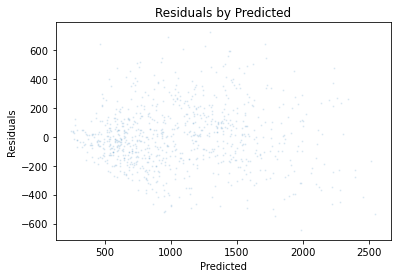

In [198]:
#### RESIDUAL ANALYSIS ####
## Heteroscedasticity and Uncorrelated Errors
plt.figure()
plt.title("Residuals by Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.scatter(model_results3.fittedvalues,model_results3.resid, s=1, alpha=0.1)

C:\Users\shani\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

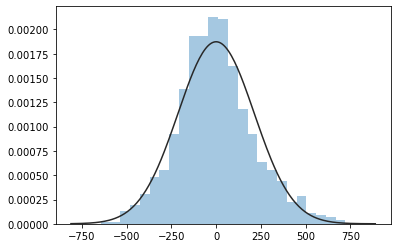

In [199]:
## Normally Distributed Errors ##
plt.figure()
sns.distplot(model_results3.resid, kde=False, fit=stats.norm)

In [200]:
plt.close('all')

<ipython-input-201-67bdda2457da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building["residuals1"] = model_results3.resid
<ipython-input-201-67bdda2457da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building["predicted1"] = model_results3.fittedvalues


<Figure size 432x288 with 0 Axes>

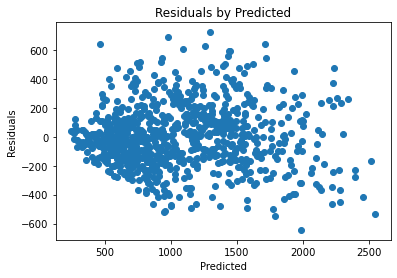

<Figure size 432x288 with 0 Axes>

In [201]:
# i Residuals by Predicted
model_building["residuals1"] = model_results3.resid
model_building["predicted1"] = model_results3.fittedvalues
plt.scatter(model_building.predicted1, model_building.residuals1)
plt.title("Residuals by Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.figure()

In [202]:
model_building["CooksD1"] = model_results3.get_influence().summary_frame().filter(["cooks_d"])

<ipython-input-202-284ca60ff5b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_building["CooksD1"] = model_results3.get_influence().summary_frame().filter(["cooks_d"])


In [203]:
model_building = model_building[(model_building.CooksD1<(4/model_building.residuals1.count()))]

In [204]:
model_results3_outliers_data_removed = sm.ols(formula= 'Attendance ~ DailyAttendancePrevDay + DailyAttendancePrev4Days + Humidity_morning_means_squared + TemperatureC_morning_means + WindSpeedKph_morning_means_Log + AvgWeeklyAttendanceAYearAgo:Monday + AvgWeeklyAttendanceAYearAgo:Tuesday + AvgWeeklyAttendanceAYearAgo:Wednesday + AvgWeeklyAttendanceAYearAgo:Thursday + AvgWeeklyAttendanceAYearAgo:Friday + AvgWeeklyAttendanceAYearAgo:Saturday + AvgWeeklyAttendanceAYearAgo:Sunday + Prior_Weekend_And_Businessday:Weekend + Prior_Weekend_And_Businessday:BusinessDay + AvgMonthlyAttendanceAYearAgo:January + AvgMonthlyAttendanceAYearAgo:February + AvgMonthlyAttendanceAYearAgo:March + AvgMonthlyAttendanceAYearAgo:April + AvgMonthlyAttendanceAYearAgo:May + AvgMonthlyAttendanceAYearAgo:June + AvgMonthlyAttendanceAYearAgo:July + AvgMonthlyAttendanceAYearAgo:August + AvgMonthlyAttendanceAYearAgo:September + AvgMonthlyAttendanceAYearAgo:October + AvgMonthlyAttendanceAYearAgo:November + AvgMonthlyAttendanceAYearAgo:December + AvgWeeklyAttendanceAYearAgo:SpecialEventDay + AvgWeeklyAttendanceAYearAgo:Holidays + AvgWeeklyAttendanceAYearAgo:WinterBreak + AvgWeeklyAttendanceAYearAgo:SummerBreak + RainMillimetersRatePerHour_morning_means:Has_Rain_Morning', data=model_building).fit()

In [206]:
model_results3_outliers_data_removed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     176.5
Date:                Tue, 26 Oct 2021   Prob (F-statistic):          1.78e-316
Time:                        19:21:23   Log-Likelihood:                -5048.4
No. Observations:                 768   AIC:                         1.016e+04
Df Residuals:                     736   BIC:                         1.031e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    27.1046    107.637      0.252      0.801    -184.208     238.417
DailyAttendancePrevDay                                        0.4967      0.024     20.887      0.000       0.450       0.543
DailyAttendancePrev4Days                                     -0.0459      0.019     -2.382      0.017      -0.084      -0.008
Humidity_morning_means_squared                                0.0033      0.003      0.962      0.336      -0.003       0.010
TemperatureC_morning_means                                   10.1684      3.267      3.113      0.002       3.755      16.582
WindSpeedKph_morning_means_Log                               43.9790     16.424      2.678      0.008      11.736      76.222
AvgWeeklyAttendanceAYearAgo:Monday                           -0.1346      0.053     -2.560      0.011      -0.238      -0.031
AvgWeeklyAttendanceAYearAgo:Tuesday                           0.1894      0.049      3.863      0.000       0.093       0.286
AvgWeeklyAttendanceAYearAgo:Wednesday                         0.1822      0.053      3.465      0.001       0.079       0.286
AvgWeeklyAttendanceAYearAgo:Thursday                          0.1960      0.052      3.764      0.000       0.094       0.298
AvgWeeklyAttendanceAYearAgo:Friday                            0.2210      0.049      4.554      0.000       0.126       0.316
AvgWeeklyAttendanceAYearAgo:Saturday                          0.6158      0.050     12.343      0.000       0.518       0.714
AvgWeeklyAttendanceAYearAgo:Sunday                            0.2268      0.053      4.296      0.000       0.123       0.330
Prior_Weekend_And_Businessday:Weekend                         0.1519      0.025      6.084      0.000       0.103       0.201
Prior_Weekend_And_Businessday:BusinessDay                    -0.0388      0.018     -2.136      0.033      -0.074      -0.003
AvgMonthlyAttendanceAYearAgo:January                         -0.1216      0.081     -1.493      0.136      -0.281       0.038
AvgMonthlyAttendanceAYearAgo:February                         0.0286      0.105      0.274      0.784      -0.177       0.234
AvgMonthlyAttendanceAYearAgo:March                            0.1136      0.083      1.373      0.170      -0.049       0.276
AvgMonthlyAttendanceAYearAgo:April                            0.0459      0.071      0.643      0.520      -0.094       0.186
AvgMonthlyAttendanceAYearAgo:May                             -0.0020      0.092     -0.021      0.983      -0.183       0.179
AvgMonthlyAttendanceAYearAgo:June                            -0.1688      0.098     -1.729      0.084      -0.360       0.023
AvgMonthlyAttendanceAYearAgo:July                          

In [208]:
hold_out['Humidity_open_mean_squared'] = hold_out.Humidity_open_mean*hold_out.Humidity_open_mean
hold_out['Has_Rain_Open'] = np.where(hold_out.RainMillimetersRatePerHour_open_mean == 0, 0, 1)
hold_out['WindSpeedKph_open_mean_Log'] = np.log(hold_out.WindSpeedKph_open_mean)

<ipython-input-208-8a4396b105f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold_out['Humidity_open_mean_squared'] = hold_out.Humidity_open_mean*hold_out.Humidity_open_mean
<ipython-input-208-8a4396b105f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold_out['Has_Rain_Open'] = np.where(hold_out.RainMillimetersRatePerHour_open_mean == 0, 0, 1)
<ipython-input-208-8a4396b105f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [209]:
#Predict using the model trained with outliers removed from the sample
out_of_sample_predictions_robust1 =  model_results3_outliers_data_removed.predict(hold_out)

In [210]:
out_of_sample_predictions_robust1

Date
2018-01-03    1344.272335
2018-01-04    1125.552517
2018-01-06    1874.488357
2018-01-07    1614.189431
2018-01-08     722.733996
                 ...     
2018-12-24     796.723742
2018-12-27    1620.049209
2018-12-28    1783.431551
2018-12-30    2248.707281
2018-12-31    1128.189494
Length: 356, dtype: float64

### After comparing a model with the morning means for temperature and a model with the temperature when the Aquarium was opened, we found that the R ² for the morning means was 73.8% and the model with the open temperatures had an R ² of 83.4% so using the open temperature is a better model.